# Untersuchung der Entfernung zwischen HACI-Schwerpunkten und lokalen Minima im IR-10,8-µm-Kanal

Um den HACI-Objekten die richtigen Satellitenobjekte zuzuordnen, ist eine Parallaxenkorrektur nötig. Entsprechen der Literatur und theoretischer Überlegungen sollte es dabei systematische Verschiebungen geben. In diesem Notebook sollen sie untersucht werden.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from standard_config import *
import sys
sys.path.append("{}/utils/tracking".format(local_home_path))

from skimage.morphology import h_minima

from l15_msevi import msevi as msv

from io_tools import radolan
import MSGtools as mst

from analysis_tools import grid_and_interpolation as gi

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
from plotting_tools.colormaps import enhanced_colormap
emap=enhanced_colormap(vmin=210,vmed=240,vmax=300)

from scipy import ndimage as ndi

import tqdm

from analysis_tools import parallax as px

import fixed_colourbar as fc

import seaborn as sns
sns.set_context("talk")

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Vorgehensweise

Für die Untersuchung wird wie folgt vorgegangen:

1. Schwerpunkt des HACI-Objekts zum Auslösungszeitpunkt ermitteln
2. Diesen Schwerpunkt in das MSG-Koordinatensystem transformieren
3. Im IR-10,8-µm-Feld zum Auslösungszeitpunkt lokale Minima mit einer Mindesttiefe von 5&thinsp;K heraussuchen
4. Abstände zwischen dem transformierten HACI-Schwerpunkt und den lokalen Minima in einer Nachbarschaft um den transformierten HACI-Schwerpunkt ermitteln
5. Lokales Minimum mit dem geringsten Abstand dem transformierten HACI-Schwerpunkt zuordnen.

## 2. Vorüberlegungen: Parallaxenkorrektur

Die Sichtgeometrie vom Satelliten aus führt dazu, dass die Wolkenoberseiten gegenüber ihrer wahren Position verschoben abgebildet werden. Dieser Effekt wird umso größer, je höher die Wolkenoberseite ist, und je weiter die Wolke von der Satellitenposition entfernt ist.

Ausgehend von den geodätischen Koordinaten eines Wolkenpunktes (&phi;<sub>g</sub> und &lambda;<sub>g</sub>), der Wolkenhöhe dieses Punktes <i>h</i>, dem Äquatorradius <i>r</i><sub>Äquator</sub>&thinsp;=&thinsp;6378,17&thinsp;km und dem Polradius <i>r</i><sub>Pol</sub>&thinsp;=&thinsp;6356,58&thinsp;km des verwendeten Elipsoides sowie der Satellitenhöhe <i>h</i><sub>Satellit</sub>&thinsp;=&thinsp;35787,22&thinsp;km kann die Parallaxenverschiebung berechnet werden.

In [2]:
lat = 54
lon = 15
h = 15000

In [3]:
corr_lons = []
corr_lats = []

for hh in np.arange(0,16000,1000):
    loc, lac = px.parallax_correction(lon, lat, hh, satlon = 9.5)
    
    corr_lons.append(loc)
    corr_lats.append(lac)

In [4]:
slon,slat = mst.get_msg_lon_lat('eu')

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [5]:
idx_corr = gi.get_index_kdtree(np.array([[corr_lons],[corr_lats]]),slon,slat)

In [52]:
msg_i_corr = []
msg_j_corr = []
dist = []
for ii, idx in enumerate(idx_corr):
    i = idx[0][0]
    j = idx[1][0]
    d = np.sqrt((idx_corr[0][0][0] - i)**2 + (idx_corr[0][1][0] - j)**2)
    
    msg_i_corr.append(i)
    msg_j_corr.append(j)
    dist.append(d)

Das ergibt für &phi;<sub>g</sub>&thinsp;=&thinsp;54°N, &lambda;<sub>g</sub>&thinsp;=&thinsp;14°O und <i>h</i>&thinsp;=&thinsp;{{print("{:.0f}".format(h))}}&thinsp;m nach der Parallaxenkorrektur: &phi;<sub>korrigiert</sub> = 53.474°N und &lambda;<sub>korrigiert</sub> = 14.949°O.


Wie zu erwarten ist die Wolkenoberkante bei einem Punkt, der so nahe an der geodätischen Länge des Satelliten liegt fast nur Richtung Norden verschoben. Die Verschiebung beträgt 0,253° Richtung Norden und 0,051° in Richtung Osten. Das entspricht einer Verschiebung um 4 MSG-Standardpixel. Das ist gleichtzeitig in etwa die Maximal mögliche Parallaxenverschiebung, da nicht zu erwarten ist, dass die Wolken höher sind. 

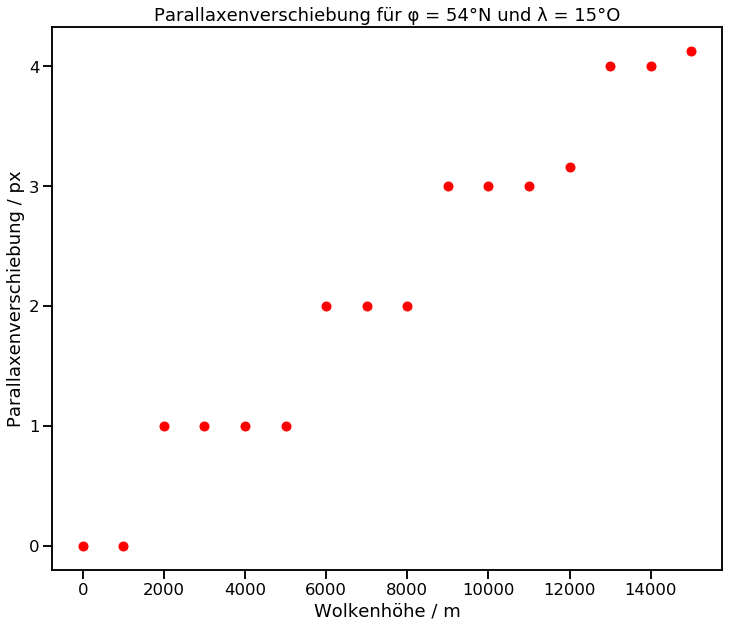

In [7]:
fig,ax = plt.subplots(1,1,figsize=(12,10))
ax.plot(np.arange(0,16000,1000),dist,'ro')
ax.set_xlabel("Wolkenhöhe / m")
ax.set_ylabel("Parallaxenverschiebung / px")
ax.set_title(u"Parallaxenverschiebung für φ = 54°N und λ = 15°O");

## 3. HACI-Fälle laden

Als nächstes laden wir die HACI Fälle.

In [8]:
haci_cases = pd.read_csv("{}/HACI_bbox_data/HACI_bbox_data_filtered.csv".format(local_data_path))

In [9]:
year = [int(row.date[:4]) for i,row in haci_cases.iterrows()]

In [10]:
haci_cases = haci_cases.assign(year=year)

## 4. Mittelpunkte der Startumgebungsbox berechnen

In [11]:
l_cen0 = (haci_cases.l00 + haci_cases.l01) // 2
c_cen0 = (haci_cases.c00 + haci_cases.c01) // 2

In [12]:
haci_cases = haci_cases.assign(l_start = l_cen0,c_start=c_cen0)

## 5. Mittelpunkte in geodätische und MSG-Koordinaten umwandeln

Vorbereitete RADOLAN-RX-Koordinaten laden.

In [13]:
r = radolan.Radolan()

Vorbereitete MSG-EU-Koordinaten laden.

In [14]:
slon, slat = mst.get_msg_lon_lat('eu')

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


RADOLAN-RX-Indexkoordinaten umwandeln.

In [15]:
lon_centre = r.lon[l_cen0,c_cen0]
lat_centre = r.lat[l_cen0,c_cen0]

Nächstes passendes MSG-Pixel finden.

In [16]:
lc_msg = gi.get_index_kdtree(np.array([[lat_centre],[lon_centre]]),slat,slon)

In [17]:
l_msg_eu = []
c_msg_eu = []

for coord in lc_msg:
    l_msg_eu.append(coord[0][0])
    c_msg_eu.append(coord[1][0])

In [18]:
haci_cases = haci_cases.assign(l_msg_eu= l_msg_eu,c_msg_eu = c_msg_eu)

Als nächstes speichern wir die ermittelten Koordinaten.

In [19]:
haci_cases.to_csv("{}/HACI_bbox_data/HACI_bbox_data_filtered.csv".format(local_data_path),index=False)

## 6. Finde das nächste lokale Minimum zu dem HACI-Schwerpunkt 

Als nächstes sehen wir uns den Abstand zwischen möglichen zu einem HACI-Objekt gehörenden Satellitenobjekten an. Das mögliche Satellitenobjekt wird erstmal nur durch sein lokales Minimum dargestellt und wir sehen uns auch erstmal nur ein paar Beispielfälle an.

In [20]:
haci_subset = haci_cases[haci_cases.year==2013]

Jetzt müssen wir für jedes HACI-Objekt das entsprechende IR-10,8-µm-Feld laden. Mögliche Parallaxenverschiebungen liegen in Deuschtland für 15&thinsp;km hohe Wolken bei ca. 4 MSG-Pixeln. Also müssen wir uns nicht das ganze Feld ansehen, sondern konzentrieren uns auf einen Bereich. Der Bereich sollte etwas größer sein als die 4&thinsp;px, da nicht zu erwarten ist, dass der HACI-Schwerpunkt und das Objektminimum immer identisch sind. Deshalb verdoppeln wir zur Sicherheit den Suchbereich auf 10&thinsp;px&thinsp;&times;&thinsp;10&thinsp;px um den HACI-Schwerpunkt.

In [21]:
case = haci_subset.iloc[50]

In [22]:
case_time = dt.datetime(int(case.date.split("-")[0]),
                        int(case.date.split("-")[1]),
                        int(case.date.split("-")[2]),
                        int(case.time.split(":")[0]),
                        int(case.time.split(":")[1]))

In [23]:
s = msv.MSevi(time=case_time,chan_list=["IR_108"],region='eu',scan_type='rss')
s.rad2bt()
ir108 = s.bt['IR_108']

Region suggests use of hdf file


In [24]:
cth = mst.get_nwcsaf_prod("CTTH_HEIGHT",case_time,calibrate=True)

In [25]:
box_size=10

In [26]:
ir108_cutout = gi.cutout_field4box(ir108,(case.l_msg_eu,case.c_msg_eu),box_size)
cth_cutout = gi.cutout_field4box(cth,(case.l_msg_eu,case.c_msg_eu),box_size)

Als erstes sehen wir uns für einen Beispielfall einen 10&thinsp;px&thinsp;&times;&thinsp;10&thinsp;px-Ausschnitt um den HACI-Schwerpunkt an.

In [27]:
lmins = h_minima(ir108,5)

In [28]:
lmin_cutout = gi.cutout_field4box(lmins,(case.l_msg_eu,case.c_msg_eu),box_size)

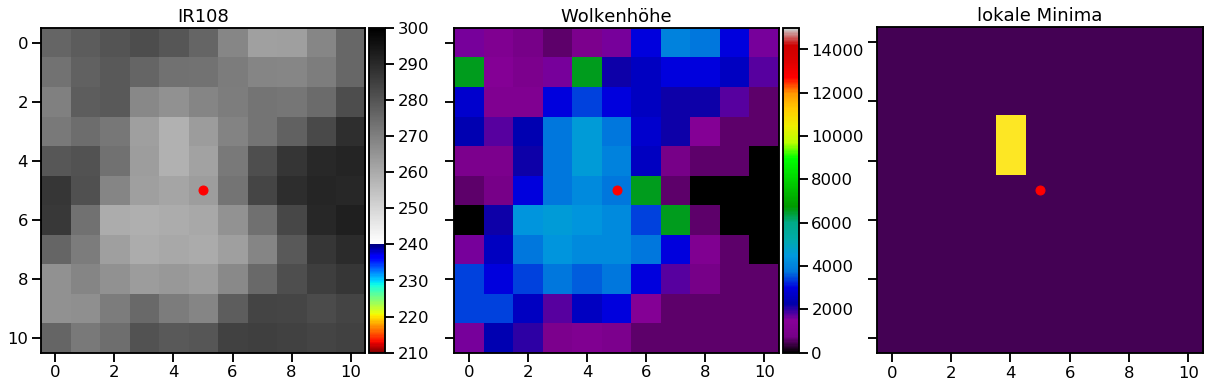

In [29]:
fig,ax = plt.subplots(1,3,figsize=(21,6),sharex=True,sharey=True)
p0 = ax[0].imshow(ir108_cutout,vmin=210,vmax=300,cmap=emap)
ax[0].set_title("IR108")
fc.colourbar(p0)
p1 = ax[1].imshow(cth_cutout,vmin=0,vmax=15000,cmap='nipy_spectral')
ax[1].set_title("Wolkenhöhe")
fc.colourbar(p1)
p2 = ax[2].imshow(lmin_cutout,vmin=0,vmax=1)
ax[2].set_title("lokale Minima")
ax[0].plot(box_size//2,box_size//2,'ro')
ax[1].plot(box_size//2,box_size//2,'ro')
ax[2].plot(box_size//2,box_size//2,'ro')

Die Wolkenhöhe am HACI-Schwerpunkt beträgt 3800 m. Damit sollte die Parallaxenveschiebung im Bereich von 1&thinsp;px bis 2&thinsp;px liegen. Das heißt, dass lokale Minimum im Ausschnitt tatsächlich zu dem HACI-Objekt gehören sollte.

Als nächstes berechnen wir den quadratischen Abstand zum lokalen Minima.

In [32]:
haci_centroid = np.array([box_size//2,box_size//2])

In [33]:
min_loc_labeled,nobj = ndi.label(lmin_cutout)

In [34]:
min_locs = ndi.center_of_mass(lmin_cutout,min_loc_labeled,np.arange(1,nobj+1))

In [37]:
distances = []

for i,ml in enumerate(min_locs):
    p = np.array([ml[0],ml[1]])
    
    dist = np.linalg.norm(p-haci_centroid)
    distances.append(dist)

In [40]:
print("Die Entfernung zum lokalen Minimum beträgt {:.2f} px.".format(distances[0]))

Die Entfernung zum lokalen Minimum beträgt 1.80 px.


In [41]:
def haci_time2datatime(case):
    case_time = dt.datetime(int(case.date.split("-")[0]),
                            int(case.date.split("-")[1]),
                            int(case.date.split("-")[2]),
                            int(case.time.split(":")[0]),
                            int(case.time.split(":")[1]))#
    return(case_time)

def load_data(case_time):
    s = msv.MSevi(time=case_time,chan_list=["IR_108"],region='eu',scan_type='rss');
    s.rad2bt()
    ir108 = s.bt['IR_108']
    
    cth = mst.get_nwcsaf_prod("CTTH_HEIGHT",case_time,calibrate=True)
    
    return {'ir108':ir108,
            'cth':cth}

def cutout_roi(field,case_data,box_size):
    return  gi.cutout_field4box(field,(case_data.l_msg_eu,
                                       case_data.c_msg_eu),box_size)

In [42]:
box_size=5
min_depth = 3
haci_centroid = np.array([box_size//2,box_size//2])

In [43]:
centroid_distances = []

for i, row in tqdm.tqdm(haci_subset.iterrows(), total=haci_subset.time.shape[0]):
    try:
        case_time = haci_time2datatime(row)

        case_data = load_data(case_time)

        lmins = h_minima(case_data['ir108'],min_depth)

        # cutouts
        ir108_cutout = cutout_roi(case_data['ir108'],row,box_size)
        #cth_cutout = cutout_roi(case_data['cth'],cth,row,box_size)
        lmin_cutout = cutout_roi(lmins,row,box_size)

        lmin_cutout_labeled, n_lmins = ndi.label(lmin_cutout)

        lmin_centroids = ndi.center_of_mass(lmin_cutout,lmin_cutout_labeled,np.arange(1,n_lmins+1))
        
        distances = []

        for i,ml in enumerate(lmin_centroids):
            p = np.array(ml)

            dist = np.linalg.norm(p-haci_centroid)
            distances.append(dist)

        centroid_distances.append(np.min(distances))
        
        #cth_point = cth_cutout[cth_cutout.shape[0]//2,cth_cutout.shape[1]//2]
        #cloud_heights.append(cth_point)
    except:
        centroid_distances.append(np.nan)
    #    cloud_heights.append(np.nan)

  0%|          | 5/1128 [00:00<00:24, 45.80it/s]/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/01/31/msg?-sevi-20130131t1130z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/01/31/msg?-sevi-20130131t1130z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/01/31/msg?-sevi-20130131t1725z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/01/31/msg?-sevi-20130131t1725z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/02/01/msg?-sevi-20130201t0240z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/02/01/msg?-sevi-20130201t0240z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/02/05/msg?-sevi-20130205t

  1%|          | 8/1128 [00:00<01:02, 17.94it/s]

Region suggests use of hdf file
Region suggests use of hdf file


  1%|          | 10/1128 [00:01<02:45,  6.77it/s]

Region suggests use of hdf file


  1%|          | 11/1128 [00:01<03:58,  4.69it/s]

Region suggests use of hdf file


  1%|          | 12/1128 [00:01<04:48,  3.87it/s]

Region suggests use of hdf file


  1%|          | 13/1128 [00:02<05:25,  3.43it/s]

Region suggests use of hdf file


  1%|          | 14/1128 [00:02<05:53,  3.15it/s]

Region suggests use of hdf file


  1%|▏         | 15/1128 [00:03<06:05,  3.04it/s]

Region suggests use of hdf file


  1%|▏         | 16/1128 [00:03<06:21,  2.92it/s]

Region suggests use of hdf file


  2%|▏         | 17/1128 [00:03<06:30,  2.84it/s]

Region suggests use of hdf file


  2%|▏         | 18/1128 [00:04<06:42,  2.76it/s]

Region suggests use of hdf file


  2%|▏         | 19/1128 [00:04<06:42,  2.75it/s]

Region suggests use of hdf file


  2%|▏         | 20/1128 [00:04<06:51,  2.70it/s]

Region suggests use of hdf file


  2%|▏         | 21/1128 [00:05<10:23,  1.78it/s]

Region suggests use of hdf file


  2%|▏         | 22/1128 [00:06<09:17,  1.98it/s]

Region suggests use of hdf file


  2%|▏         | 23/1128 [00:06<08:27,  2.18it/s]

Region suggests use of hdf file


  2%|▏         | 24/1128 [00:07<07:52,  2.33it/s]

Region suggests use of hdf file


  2%|▏         | 25/1128 [00:07<07:23,  2.49it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/04/15/msg?-sevi-20130415t0530z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit130790878/H-000-MSG1__-MSG1_RSS____-IR_108___-000007___-201304150530-__
... reading  /tmp/hrit130790878/H-000-MSG1__-MSG1_RSS____-IR_108___-000008___-201304150530-__

Combine segments

Do calibration
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/04/15/SAFNWC_MSG?_CTTH_201304150530_rss-eu______.c?.h5  does not exist!


  2%|▏         | 26/1128 [00:08<11:23,  1.61it/s]

Region suggests use of hdf file


  2%|▏         | 27/1128 [00:08<09:51,  1.86it/s]

Region suggests use of hdf file


  2%|▏         | 28/1128 [00:09<08:44,  2.10it/s]

Region suggests use of hdf file


  3%|▎         | 29/1128 [00:09<07:54,  2.32it/s]

Region suggests use of hdf file


  3%|▎         | 30/1128 [00:09<07:23,  2.48it/s]

Region suggests use of hdf file


  3%|▎         | 31/1128 [00:10<06:58,  2.62it/s]

Region suggests use of hdf file


  3%|▎         | 32/1128 [00:10<06:42,  2.72it/s]

Region suggests use of hdf file


  3%|▎         | 33/1128 [00:10<06:30,  2.80it/s]

Region suggests use of hdf file


  3%|▎         | 34/1128 [00:11<06:22,  2.86it/s]

Region suggests use of hdf file


  3%|▎         | 35/1128 [00:11<06:12,  2.93it/s]

Region suggests use of hdf file


  3%|▎         | 36/1128 [00:11<06:06,  2.98it/s]

Region suggests use of hdf file


  3%|▎         | 37/1128 [00:12<05:58,  3.04it/s]

Region suggests use of hdf file


  3%|▎         | 38/1128 [00:12<05:54,  3.07it/s]

Region suggests use of hdf file


  3%|▎         | 39/1128 [00:12<05:53,  3.08it/s]

Region suggests use of hdf file


  4%|▎         | 40/1128 [00:13<05:53,  3.08it/s]

Region suggests use of hdf file


  4%|▎         | 41/1128 [00:13<05:51,  3.09it/s]

Region suggests use of hdf file


  4%|▎         | 42/1128 [00:13<05:50,  3.10it/s]

Region suggests use of hdf file


  4%|▍         | 43/1128 [00:14<05:48,  3.11it/s]

Region suggests use of hdf file


  4%|▍         | 44/1128 [00:14<05:47,  3.12it/s]

Region suggests use of hdf file


  4%|▍         | 45/1128 [00:14<05:48,  3.11it/s]

Region suggests use of hdf file


  4%|▍         | 46/1128 [00:15<05:46,  3.12it/s]

Region suggests use of hdf file


  4%|▍         | 47/1128 [00:15<05:43,  3.15it/s]

Region suggests use of hdf file


  4%|▍         | 48/1128 [00:15<05:41,  3.17it/s]

Region suggests use of hdf file


  4%|▍         | 49/1128 [00:15<05:42,  3.15it/s]

Region suggests use of hdf file


  4%|▍         | 50/1128 [00:16<05:42,  3.15it/s]

Region suggests use of hdf file


  5%|▍         | 51/1128 [00:16<05:48,  3.09it/s]

Region suggests use of hdf file


  5%|▍         | 52/1128 [00:16<05:52,  3.05it/s]

Region suggests use of hdf file


  5%|▍         | 53/1128 [00:17<05:54,  3.03it/s]

Region suggests use of hdf file


  5%|▍         | 54/1128 [00:17<05:52,  3.05it/s]

Region suggests use of hdf file


  5%|▍         | 55/1128 [00:17<05:49,  3.07it/s]

Region suggests use of hdf file


  5%|▍         | 56/1128 [00:18<05:49,  3.07it/s]

Region suggests use of hdf file


  5%|▌         | 57/1128 [00:18<05:50,  3.05it/s]

Region suggests use of hdf file


  5%|▌         | 58/1128 [00:18<05:51,  3.05it/s]

Region suggests use of hdf file


  5%|▌         | 59/1128 [00:19<05:50,  3.05it/s]

Region suggests use of hdf file


  5%|▌         | 60/1128 [00:19<05:47,  3.08it/s]

Region suggests use of hdf file


  5%|▌         | 61/1128 [00:19<05:45,  3.09it/s]

Region suggests use of hdf file


  5%|▌         | 62/1128 [00:20<05:45,  3.08it/s]

Region suggests use of hdf file


  6%|▌         | 63/1128 [00:20<05:48,  3.06it/s]

Region suggests use of hdf file


  6%|▌         | 64/1128 [00:20<05:50,  3.04it/s]

Region suggests use of hdf file


  6%|▌         | 65/1128 [00:21<05:52,  3.02it/s]

Region suggests use of hdf file


  6%|▌         | 66/1128 [00:21<05:52,  3.01it/s]

Region suggests use of hdf file


  6%|▌         | 67/1128 [00:21<05:51,  3.02it/s]

Region suggests use of hdf file


  6%|▌         | 68/1128 [00:22<05:51,  3.01it/s]

Region suggests use of hdf file


  6%|▌         | 69/1128 [00:22<05:50,  3.02it/s]

Region suggests use of hdf file


  6%|▌         | 70/1128 [00:22<05:52,  3.00it/s]

Region suggests use of hdf file


  6%|▋         | 71/1128 [00:23<05:52,  3.00it/s]

Region suggests use of hdf file


  6%|▋         | 72/1128 [00:23<05:51,  3.01it/s]

Region suggests use of hdf file


  6%|▋         | 73/1128 [00:23<05:52,  2.99it/s]

Region suggests use of hdf file


  7%|▋         | 74/1128 [00:24<05:54,  2.98it/s]

Region suggests use of hdf file


  7%|▋         | 75/1128 [00:24<05:53,  2.98it/s]

Region suggests use of hdf file


  7%|▋         | 76/1128 [00:24<05:54,  2.97it/s]

Region suggests use of hdf file


  7%|▋         | 77/1128 [00:25<05:54,  2.97it/s]

Region suggests use of hdf file


  7%|▋         | 78/1128 [00:25<05:52,  2.97it/s]

Region suggests use of hdf file


  7%|▋         | 79/1128 [00:25<05:49,  3.00it/s]

Region suggests use of hdf file


  7%|▋         | 80/1128 [00:26<05:52,  2.97it/s]

Region suggests use of hdf file


  7%|▋         | 81/1128 [00:26<05:54,  2.95it/s]

Region suggests use of hdf file


  7%|▋         | 82/1128 [00:26<05:57,  2.93it/s]

Region suggests use of hdf file


  7%|▋         | 83/1128 [00:27<05:58,  2.92it/s]

Region suggests use of hdf file


  7%|▋         | 84/1128 [00:27<05:58,  2.91it/s]

Region suggests use of hdf file


  8%|▊         | 85/1128 [00:27<05:58,  2.91it/s]

Region suggests use of hdf file


  8%|▊         | 86/1128 [00:28<05:59,  2.90it/s]

Region suggests use of hdf file


  8%|▊         | 87/1128 [00:28<05:58,  2.90it/s]

Region suggests use of hdf file


  8%|▊         | 88/1128 [00:29<05:58,  2.90it/s]

Region suggests use of hdf file


  8%|▊         | 89/1128 [00:29<05:57,  2.91it/s]

Region suggests use of hdf file


  8%|▊         | 90/1128 [00:29<05:57,  2.91it/s]

Region suggests use of hdf file


  8%|▊         | 91/1128 [00:30<05:56,  2.91it/s]

Region suggests use of hdf file


  8%|▊         | 92/1128 [00:30<05:30,  3.13it/s]

Region suggests use of hdf file
Region suggests use of hdf file


  8%|▊         | 95/1128 [00:30<03:55,  4.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file


  9%|▊         | 97/1128 [00:31<03:21,  5.12it/s]

Region suggests use of hdf file
Region suggests use of hdf file


  9%|▊         | 98/1128 [00:31<03:11,  5.38it/s]

Region suggests use of hdf file


  9%|▉         | 99/1128 [00:31<03:33,  4.82it/s]

Region suggests use of hdf file


  9%|▉         | 100/1128 [00:31<04:14,  4.04it/s]

Region suggests use of hdf file


  9%|▉         | 101/1128 [00:32<04:43,  3.63it/s]

Region suggests use of hdf file


  9%|▉         | 102/1128 [00:32<05:02,  3.39it/s]

Region suggests use of hdf file


  9%|▉         | 103/1128 [00:32<05:16,  3.24it/s]

Region suggests use of hdf file


  9%|▉         | 104/1128 [00:33<05:25,  3.15it/s]

Region suggests use of hdf file


  9%|▉         | 105/1128 [00:33<05:32,  3.08it/s]

Region suggests use of hdf file


  9%|▉         | 106/1128 [00:33<05:36,  3.04it/s]

Region suggests use of hdf file


  9%|▉         | 107/1128 [00:34<05:39,  3.01it/s]

Region suggests use of hdf file


 10%|▉         | 108/1128 [00:34<05:39,  3.00it/s]

Region suggests use of hdf file


 10%|▉         | 109/1128 [00:34<05:38,  3.01it/s]

Region suggests use of hdf file


 10%|▉         | 110/1128 [00:35<05:36,  3.03it/s]

Region suggests use of hdf file


 10%|▉         | 111/1128 [00:35<05:36,  3.03it/s]

Region suggests use of hdf file


 10%|▉         | 112/1128 [00:35<05:37,  3.01it/s]

Region suggests use of hdf file


 10%|█         | 113/1128 [00:36<05:39,  2.99it/s]

Region suggests use of hdf file


 10%|█         | 114/1128 [00:36<05:41,  2.97it/s]

Region suggests use of hdf file


 10%|█         | 115/1128 [00:36<05:42,  2.96it/s]

Region suggests use of hdf file


 10%|█         | 116/1128 [00:37<05:42,  2.95it/s]

Region suggests use of hdf file


 10%|█         | 117/1128 [00:37<05:43,  2.95it/s]

Region suggests use of hdf file


 10%|█         | 118/1128 [00:37<05:44,  2.94it/s]

Region suggests use of hdf file


 11%|█         | 119/1128 [00:38<05:45,  2.92it/s]

Region suggests use of hdf file


 11%|█         | 120/1128 [00:38<05:44,  2.92it/s]

Region suggests use of hdf file


 11%|█         | 121/1128 [00:38<05:45,  2.92it/s]

Region suggests use of hdf file


 11%|█         | 122/1128 [00:39<05:43,  2.93it/s]

Region suggests use of hdf file


 11%|█         | 123/1128 [00:39<05:44,  2.92it/s]

Region suggests use of hdf file


 11%|█         | 124/1128 [00:39<05:43,  2.92it/s]

Region suggests use of hdf file


 11%|█         | 125/1128 [00:40<05:42,  2.93it/s]

Region suggests use of hdf file


 11%|█         | 126/1128 [00:40<05:40,  2.94it/s]

Region suggests use of hdf file


 11%|█▏        | 127/1128 [00:40<05:39,  2.95it/s]

Region suggests use of hdf file


 11%|█▏        | 128/1128 [00:41<05:37,  2.96it/s]

Region suggests use of hdf file


 11%|█▏        | 129/1128 [00:41<05:35,  2.98it/s]

Region suggests use of hdf file


 12%|█▏        | 130/1128 [00:41<05:33,  2.99it/s]

Region suggests use of hdf file


 12%|█▏        | 131/1128 [00:42<05:32,  3.00it/s]

Region suggests use of hdf file


 12%|█▏        | 132/1128 [00:42<05:30,  3.01it/s]

Region suggests use of hdf file


 12%|█▏        | 133/1128 [00:42<05:28,  3.03it/s]

Region suggests use of hdf file


 12%|█▏        | 134/1128 [00:43<05:26,  3.05it/s]

Region suggests use of hdf file


 12%|█▏        | 135/1128 [00:43<05:24,  3.06it/s]

Region suggests use of hdf file


 12%|█▏        | 136/1128 [00:43<05:24,  3.06it/s]

Region suggests use of hdf file


 12%|█▏        | 137/1128 [00:44<05:25,  3.05it/s]

Region suggests use of hdf file


 12%|█▏        | 138/1128 [00:44<05:25,  3.04it/s]

Region suggests use of hdf file


 12%|█▏        | 139/1128 [00:44<05:25,  3.04it/s]

Region suggests use of hdf file


 12%|█▏        | 140/1128 [00:45<05:23,  3.05it/s]

Region suggests use of hdf file


 12%|█▎        | 141/1128 [00:45<05:23,  3.05it/s]

Region suggests use of hdf file


 13%|█▎        | 142/1128 [00:45<05:22,  3.05it/s]

Region suggests use of hdf file


 13%|█▎        | 143/1128 [00:46<05:22,  3.06it/s]

Region suggests use of hdf file


 13%|█▎        | 144/1128 [00:46<05:21,  3.06it/s]

Region suggests use of hdf file


 13%|█▎        | 145/1128 [00:46<05:21,  3.06it/s]

Region suggests use of hdf file


 13%|█▎        | 146/1128 [00:47<05:21,  3.05it/s]

Region suggests use of hdf file


 13%|█▎        | 147/1128 [00:47<05:20,  3.06it/s]

Region suggests use of hdf file


 13%|█▎        | 148/1128 [00:47<05:19,  3.06it/s]

Region suggests use of hdf file


 13%|█▎        | 149/1128 [00:48<05:20,  3.06it/s]

Region suggests use of hdf file


 13%|█▎        | 150/1128 [00:48<05:20,  3.05it/s]

Region suggests use of hdf file


 13%|█▎        | 151/1128 [00:48<05:26,  2.99it/s]

Region suggests use of hdf file


 13%|█▎        | 152/1128 [00:49<05:29,  2.96it/s]

Region suggests use of hdf file


 14%|█▎        | 153/1128 [00:49<05:31,  2.94it/s]

Region suggests use of hdf file


 14%|█▎        | 154/1128 [00:49<05:32,  2.93it/s]

Region suggests use of hdf file


 14%|█▎        | 155/1128 [00:50<05:31,  2.93it/s]

Region suggests use of hdf file


 14%|█▍        | 156/1128 [00:50<05:30,  2.95it/s]

Region suggests use of hdf file


 14%|█▍        | 157/1128 [00:50<05:27,  2.97it/s]

Region suggests use of hdf file


 14%|█▍        | 158/1128 [00:51<05:23,  3.00it/s]

Region suggests use of hdf file


 14%|█▍        | 159/1128 [00:51<05:21,  3.01it/s]

Region suggests use of hdf file


 14%|█▍        | 160/1128 [00:51<05:19,  3.03it/s]

Region suggests use of hdf file


 14%|█▍        | 161/1128 [00:52<05:17,  3.05it/s]

Region suggests use of hdf file


 14%|█▍        | 162/1128 [00:52<05:14,  3.07it/s]

Region suggests use of hdf file


 14%|█▍        | 163/1128 [00:52<05:12,  3.08it/s]

Region suggests use of hdf file


 15%|█▍        | 164/1128 [00:53<05:11,  3.10it/s]

Region suggests use of hdf file


 15%|█▍        | 165/1128 [00:53<05:09,  3.11it/s]

Region suggests use of hdf file


 15%|█▍        | 166/1128 [00:53<05:09,  3.11it/s]

Region suggests use of hdf file


 15%|█▍        | 167/1128 [00:54<05:13,  3.07it/s]

Region suggests use of hdf file


 15%|█▍        | 168/1128 [00:54<05:15,  3.04it/s]

Region suggests use of hdf file


 15%|█▍        | 169/1128 [00:54<05:14,  3.05it/s]

Region suggests use of hdf file


 15%|█▌        | 170/1128 [00:55<05:11,  3.08it/s]

Region suggests use of hdf file


 15%|█▌        | 171/1128 [00:55<05:14,  3.04it/s]

Region suggests use of hdf file


 15%|█▌        | 172/1128 [00:55<05:16,  3.02it/s]

Region suggests use of hdf file


 15%|█▌        | 173/1128 [00:56<05:18,  3.00it/s]

Region suggests use of hdf file


 15%|█▌        | 174/1128 [00:56<05:19,  2.99it/s]

Region suggests use of hdf file


 16%|█▌        | 175/1128 [00:56<05:19,  2.98it/s]

Region suggests use of hdf file


 16%|█▌        | 176/1128 [00:57<05:17,  3.00it/s]

Region suggests use of hdf file


 16%|█▌        | 177/1128 [00:57<05:15,  3.01it/s]

Region suggests use of hdf file


 16%|█▌        | 178/1128 [00:57<05:13,  3.03it/s]

Region suggests use of hdf file


 16%|█▌        | 179/1128 [00:58<05:13,  3.03it/s]

Region suggests use of hdf file


 16%|█▌        | 180/1128 [00:58<05:11,  3.04it/s]

Region suggests use of hdf file


 16%|█▌        | 181/1128 [00:58<05:08,  3.07it/s]

Region suggests use of hdf file


 16%|█▌        | 182/1128 [00:59<05:06,  3.08it/s]

Region suggests use of hdf file


 16%|█▌        | 183/1128 [00:59<05:05,  3.09it/s]

Region suggests use of hdf file


 16%|█▋        | 184/1128 [00:59<05:05,  3.09it/s]

Region suggests use of hdf file


 16%|█▋        | 185/1128 [01:00<05:03,  3.10it/s]

Region suggests use of hdf file


 16%|█▋        | 186/1128 [01:00<05:02,  3.11it/s]

Region suggests use of hdf file


 17%|█▋        | 187/1128 [01:00<05:02,  3.11it/s]

Region suggests use of hdf file


 17%|█▋        | 188/1128 [01:00<05:02,  3.11it/s]

Region suggests use of hdf file


 17%|█▋        | 189/1128 [01:01<05:03,  3.10it/s]

Region suggests use of hdf file


 17%|█▋        | 190/1128 [01:01<05:03,  3.09it/s]

Region suggests use of hdf file


 17%|█▋        | 191/1128 [01:01<05:03,  3.09it/s]

Region suggests use of hdf file


 17%|█▋        | 192/1128 [01:02<05:06,  3.05it/s]

Region suggests use of hdf file


 17%|█▋        | 193/1128 [01:02<05:08,  3.04it/s]

Region suggests use of hdf file


 17%|█▋        | 194/1128 [01:02<05:08,  3.03it/s]

Region suggests use of hdf file


 17%|█▋        | 195/1128 [01:03<05:08,  3.02it/s]

Region suggests use of hdf file


 17%|█▋        | 196/1128 [01:03<05:08,  3.03it/s]

Region suggests use of hdf file


 17%|█▋        | 197/1128 [01:03<05:07,  3.03it/s]

Region suggests use of hdf file


 18%|█▊        | 198/1128 [01:04<05:03,  3.06it/s]

Region suggests use of hdf file


 18%|█▊        | 199/1128 [01:04<05:04,  3.05it/s]

Region suggests use of hdf file


 18%|█▊        | 200/1128 [01:04<05:05,  3.04it/s]

Region suggests use of hdf file


 18%|█▊        | 201/1128 [01:05<05:05,  3.03it/s]

Region suggests use of hdf file


 18%|█▊        | 202/1128 [01:05<05:05,  3.03it/s]

Region suggests use of hdf file


 18%|█▊        | 203/1128 [01:05<05:06,  3.02it/s]

Region suggests use of hdf file


 18%|█▊        | 204/1128 [01:06<05:06,  3.02it/s]

Region suggests use of hdf file


 18%|█▊        | 205/1128 [01:06<05:07,  3.00it/s]

Region suggests use of hdf file


 18%|█▊        | 206/1128 [01:06<05:06,  3.00it/s]

Region suggests use of hdf file


 18%|█▊        | 207/1128 [01:07<05:08,  2.98it/s]

Region suggests use of hdf file


 18%|█▊        | 208/1128 [01:07<05:08,  2.98it/s]

Region suggests use of hdf file


 19%|█▊        | 209/1128 [01:07<05:08,  2.98it/s]

Region suggests use of hdf file


 19%|█▊        | 210/1128 [01:08<05:06,  2.99it/s]

Region suggests use of hdf file


 19%|█▊        | 211/1128 [01:08<05:04,  3.02it/s]

Region suggests use of hdf file


 19%|█▉        | 212/1128 [01:08<05:01,  3.04it/s]

Region suggests use of hdf file


 19%|█▉        | 213/1128 [01:09<05:01,  3.04it/s]

Region suggests use of hdf file


 19%|█▉        | 214/1128 [01:09<05:00,  3.04it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1350z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit1869883754/H-000-MSG2__-MSG2_RSS____-IR_108___-000007___-201305301350-__
... reading  /tmp/hrit1869883754/H-000-MSG2__-MSG2_RSS____-IR_108___-000008___-201305301350-__

Combine segments

Do calibration


 19%|█▉        | 215/1128 [01:10<08:57,  1.70it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1515z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit2251932287/H-000-MSG2__-MSG2_RSS____-IR_108___-000007___-201305301515-__
... reading  /tmp/hrit2251932287/H-000-MSG2__-MSG2_RSS____-IR_108___-000008___-201305301515-__

Combine segments

Do calibration


 19%|█▉        | 216/1128 [01:11<11:32,  1.32it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1535z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit6561264437/H-000-MSG2__-MSG2_RSS____-IR_108___-000007___-201305301535-__
... reading  /tmp/hrit6561264437/H-000-MSG2__-MSG2_RSS____-IR_108___-000008___-201305301535-__

Combine segments

Do calibration


 19%|█▉        | 217/1128 [01:13<13:25,  1.13it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1555z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit5613779288/H-000-MSG2__-MSG2_RSS____-IR_108___-000007___-201305301555-__
... reading  /tmp/hrit5613779288/H-000-MSG2__-MSG2_RSS____-IR_108___-000008___-201305301555-__

Combine segments

Do calibration


 19%|█▉        | 218/1128 [01:14<14:43,  1.03it/s]

Region suggests use of hdf file


 19%|█▉        | 219/1128 [01:14<11:47,  1.28it/s]

Region suggests use of hdf file


 20%|█▉        | 220/1128 [01:14<09:43,  1.56it/s]

Region suggests use of hdf file


 20%|█▉        | 221/1128 [01:15<08:17,  1.82it/s]

Region suggests use of hdf file


 20%|█▉        | 222/1128 [01:15<07:18,  2.07it/s]

Region suggests use of hdf file


 20%|█▉        | 223/1128 [01:15<06:38,  2.27it/s]

Region suggests use of hdf file


 20%|█▉        | 224/1128 [01:16<06:09,  2.44it/s]

Region suggests use of hdf file


 20%|█▉        | 225/1128 [01:16<05:49,  2.58it/s]

Region suggests use of hdf file


 20%|██        | 226/1128 [01:16<05:36,  2.68it/s]

Region suggests use of hdf file


 20%|██        | 227/1128 [01:17<05:27,  2.75it/s]

Region suggests use of hdf file


 20%|██        | 228/1128 [01:17<05:18,  2.82it/s]

Region suggests use of hdf file


 20%|██        | 229/1128 [01:17<05:13,  2.87it/s]

Region suggests use of hdf file


 20%|██        | 230/1128 [01:18<05:08,  2.91it/s]

Region suggests use of hdf file


 20%|██        | 231/1128 [01:18<05:01,  2.97it/s]

Region suggests use of hdf file


 21%|██        | 232/1128 [01:18<04:55,  3.04it/s]

Region suggests use of hdf file


 21%|██        | 233/1128 [01:19<04:52,  3.06it/s]

Region suggests use of hdf file


 21%|██        | 234/1128 [01:19<04:50,  3.07it/s]

Region suggests use of hdf file


 21%|██        | 235/1128 [01:19<04:49,  3.09it/s]

Region suggests use of hdf file


 21%|██        | 236/1128 [01:20<04:45,  3.12it/s]

Region suggests use of hdf file


 21%|██        | 237/1128 [01:20<04:43,  3.15it/s]

Region suggests use of hdf file


 21%|██        | 238/1128 [01:20<04:47,  3.09it/s]

Region suggests use of hdf file


 21%|██        | 239/1128 [01:21<04:49,  3.07it/s]

Region suggests use of hdf file


 21%|██▏       | 240/1128 [01:21<04:48,  3.08it/s]

Region suggests use of hdf file


 21%|██▏       | 241/1128 [01:21<04:51,  3.04it/s]

Region suggests use of hdf file


 21%|██▏       | 242/1128 [01:22<04:53,  3.02it/s]

Region suggests use of hdf file


 22%|██▏       | 243/1128 [01:22<04:50,  3.05it/s]

Region suggests use of hdf file


 22%|██▏       | 244/1128 [01:22<04:45,  3.09it/s]

Region suggests use of hdf file


 22%|██▏       | 245/1128 [01:23<04:44,  3.10it/s]

Region suggests use of hdf file


 22%|██▏       | 246/1128 [01:23<04:44,  3.10it/s]

Region suggests use of hdf file


 22%|██▏       | 247/1128 [01:23<04:47,  3.07it/s]

Region suggests use of hdf file


 22%|██▏       | 248/1128 [01:24<04:47,  3.06it/s]

Region suggests use of hdf file


 22%|██▏       | 249/1128 [01:24<04:47,  3.06it/s]

Region suggests use of hdf file


 22%|██▏       | 250/1128 [01:24<04:47,  3.06it/s]

Region suggests use of hdf file


 22%|██▏       | 251/1128 [01:25<04:48,  3.04it/s]

Region suggests use of hdf file


 22%|██▏       | 252/1128 [01:25<04:47,  3.05it/s]

Region suggests use of hdf file


 22%|██▏       | 253/1128 [01:25<04:46,  3.05it/s]

Region suggests use of hdf file


 23%|██▎       | 254/1128 [01:26<04:46,  3.05it/s]

Region suggests use of hdf file


 23%|██▎       | 255/1128 [01:26<04:46,  3.05it/s]

Region suggests use of hdf file


 23%|██▎       | 256/1128 [01:26<04:43,  3.07it/s]

Region suggests use of hdf file


 23%|██▎       | 257/1128 [01:27<04:43,  3.08it/s]

Region suggests use of hdf file


 23%|██▎       | 258/1128 [01:27<04:42,  3.08it/s]

Region suggests use of hdf file


 23%|██▎       | 259/1128 [01:27<04:43,  3.06it/s]

Region suggests use of hdf file


 23%|██▎       | 260/1128 [01:28<04:43,  3.06it/s]

Region suggests use of hdf file


 23%|██▎       | 261/1128 [01:28<04:43,  3.06it/s]

Region suggests use of hdf file


 23%|██▎       | 262/1128 [01:28<04:42,  3.06it/s]

Region suggests use of hdf file


 23%|██▎       | 263/1128 [01:29<04:44,  3.04it/s]

Region suggests use of hdf file


 23%|██▎       | 264/1128 [01:29<04:43,  3.04it/s]

Region suggests use of hdf file


 23%|██▎       | 265/1128 [01:29<04:43,  3.04it/s]

Region suggests use of hdf file


 24%|██▎       | 266/1128 [01:30<04:42,  3.05it/s]

Region suggests use of hdf file


 24%|██▎       | 267/1128 [01:30<04:43,  3.03it/s]

Region suggests use of hdf file


 24%|██▍       | 268/1128 [01:30<04:42,  3.05it/s]

Region suggests use of hdf file


 24%|██▍       | 269/1128 [01:30<04:40,  3.06it/s]

Region suggests use of hdf file


 24%|██▍       | 270/1128 [01:31<04:39,  3.07it/s]

Region suggests use of hdf file


 24%|██▍       | 271/1128 [01:31<04:40,  3.06it/s]

Region suggests use of hdf file


 24%|██▍       | 272/1128 [01:31<04:39,  3.06it/s]

Region suggests use of hdf file


 24%|██▍       | 273/1128 [01:32<04:39,  3.06it/s]

Region suggests use of hdf file


 24%|██▍       | 274/1128 [01:32<04:38,  3.07it/s]

Region suggests use of hdf file


 24%|██▍       | 275/1128 [01:32<04:38,  3.07it/s]

Region suggests use of hdf file


 24%|██▍       | 276/1128 [01:33<04:36,  3.08it/s]

Region suggests use of hdf file


 25%|██▍       | 277/1128 [01:33<04:36,  3.08it/s]

Region suggests use of hdf file


 25%|██▍       | 278/1128 [01:33<04:35,  3.09it/s]

Region suggests use of hdf file


 25%|██▍       | 279/1128 [01:34<04:35,  3.08it/s]

Region suggests use of hdf file


 25%|██▍       | 280/1128 [01:34<04:34,  3.09it/s]

Region suggests use of hdf file


 25%|██▍       | 281/1128 [01:34<04:33,  3.10it/s]

Region suggests use of hdf file


 25%|██▌       | 282/1128 [01:35<04:32,  3.10it/s]

Region suggests use of hdf file


 25%|██▌       | 283/1128 [01:35<04:31,  3.11it/s]

Region suggests use of hdf file


 25%|██▌       | 284/1128 [01:35<04:29,  3.13it/s]

Region suggests use of hdf file


 25%|██▌       | 285/1128 [01:36<04:27,  3.15it/s]

Region suggests use of hdf file


 25%|██▌       | 286/1128 [01:36<04:25,  3.17it/s]

Region suggests use of hdf file


 25%|██▌       | 287/1128 [01:36<04:25,  3.17it/s]

Region suggests use of hdf file


 26%|██▌       | 288/1128 [01:37<04:23,  3.18it/s]

Region suggests use of hdf file


 26%|██▌       | 289/1128 [01:37<04:25,  3.16it/s]

Region suggests use of hdf file


 26%|██▌       | 290/1128 [01:37<04:29,  3.11it/s]

Region suggests use of hdf file


 26%|██▌       | 291/1128 [01:38<04:29,  3.10it/s]

Region suggests use of hdf file


 26%|██▌       | 292/1128 [01:38<04:31,  3.08it/s]

Region suggests use of hdf file


 26%|██▌       | 293/1128 [01:38<04:32,  3.06it/s]

Region suggests use of hdf file


 26%|██▌       | 294/1128 [01:39<04:33,  3.05it/s]

Region suggests use of hdf file


 26%|██▌       | 295/1128 [01:39<04:33,  3.04it/s]

Region suggests use of hdf file


 26%|██▌       | 296/1128 [01:39<04:32,  3.05it/s]

Region suggests use of hdf file


 26%|██▋       | 297/1128 [01:40<04:31,  3.07it/s]

Region suggests use of hdf file


 26%|██▋       | 298/1128 [01:40<04:29,  3.08it/s]

Region suggests use of hdf file


 27%|██▋       | 299/1128 [01:40<04:29,  3.07it/s]

Region suggests use of hdf file


 27%|██▋       | 300/1128 [01:41<04:28,  3.09it/s]

Region suggests use of hdf file


 27%|██▋       | 301/1128 [01:41<04:26,  3.10it/s]

Region suggests use of hdf file


 27%|██▋       | 302/1128 [01:41<04:30,  3.06it/s]

Region suggests use of hdf file


 27%|██▋       | 303/1128 [01:42<04:36,  2.98it/s]

Region suggests use of hdf file


 27%|██▋       | 304/1128 [01:42<04:37,  2.97it/s]

Region suggests use of hdf file


 27%|██▋       | 305/1128 [01:42<04:38,  2.95it/s]

Region suggests use of hdf file


 27%|██▋       | 306/1128 [01:43<04:38,  2.95it/s]

Region suggests use of hdf file


 27%|██▋       | 307/1128 [01:43<04:39,  2.94it/s]

Region suggests use of hdf file


 27%|██▋       | 308/1128 [01:43<04:38,  2.95it/s]

Region suggests use of hdf file


 27%|██▋       | 309/1128 [01:44<04:38,  2.94it/s]

Region suggests use of hdf file


 27%|██▋       | 310/1128 [01:44<04:37,  2.95it/s]

Region suggests use of hdf file


 28%|██▊       | 311/1128 [01:44<04:37,  2.94it/s]

Region suggests use of hdf file


 28%|██▊       | 312/1128 [01:45<04:36,  2.95it/s]

Region suggests use of hdf file


 28%|██▊       | 313/1128 [01:45<04:36,  2.95it/s]

Region suggests use of hdf file


 28%|██▊       | 314/1128 [01:45<04:35,  2.95it/s]

Region suggests use of hdf file


 28%|██▊       | 315/1128 [01:46<04:36,  2.94it/s]

Region suggests use of hdf file


 28%|██▊       | 316/1128 [01:46<04:35,  2.95it/s]

Region suggests use of hdf file


 28%|██▊       | 317/1128 [01:46<04:34,  2.96it/s]

Region suggests use of hdf file


 28%|██▊       | 318/1128 [01:47<04:33,  2.97it/s]

Region suggests use of hdf file


 28%|██▊       | 319/1128 [01:47<04:34,  2.95it/s]

Region suggests use of hdf file


 28%|██▊       | 320/1128 [01:47<04:31,  2.98it/s]

Region suggests use of hdf file


 28%|██▊       | 321/1128 [01:48<04:26,  3.03it/s]

Region suggests use of hdf file


 29%|██▊       | 322/1128 [01:48<04:24,  3.04it/s]

Region suggests use of hdf file


 29%|██▊       | 323/1128 [01:48<04:25,  3.03it/s]

Region suggests use of hdf file


 29%|██▊       | 324/1128 [01:49<04:25,  3.03it/s]

Region suggests use of hdf file


 29%|██▉       | 325/1128 [01:49<04:22,  3.06it/s]

Region suggests use of hdf file


 29%|██▉       | 326/1128 [01:49<04:19,  3.08it/s]

Region suggests use of hdf file


 29%|██▉       | 327/1128 [01:50<04:18,  3.10it/s]

Region suggests use of hdf file


 29%|██▉       | 328/1128 [01:50<04:20,  3.07it/s]

Region suggests use of hdf file


 29%|██▉       | 329/1128 [01:50<04:20,  3.07it/s]

Region suggests use of hdf file


 29%|██▉       | 330/1128 [01:51<04:19,  3.07it/s]

Region suggests use of hdf file


 29%|██▉       | 331/1128 [01:51<04:19,  3.07it/s]

Region suggests use of hdf file


 29%|██▉       | 332/1128 [01:51<04:16,  3.10it/s]

Region suggests use of hdf file


 30%|██▉       | 333/1128 [01:51<04:17,  3.09it/s]

Region suggests use of hdf file


 30%|██▉       | 334/1128 [01:52<04:16,  3.09it/s]

Region suggests use of hdf file


 30%|██▉       | 335/1128 [01:52<04:20,  3.04it/s]

Region suggests use of hdf file


 30%|██▉       | 336/1128 [01:52<04:22,  3.02it/s]

Region suggests use of hdf file


 30%|██▉       | 337/1128 [01:53<04:23,  3.01it/s]

Region suggests use of hdf file


 30%|██▉       | 338/1128 [01:53<04:22,  3.01it/s]

Region suggests use of hdf file


 30%|███       | 339/1128 [01:54<04:22,  3.00it/s]

Region suggests use of hdf file


 30%|███       | 340/1128 [01:54<04:21,  3.01it/s]

Region suggests use of hdf file


 30%|███       | 341/1128 [01:54<04:20,  3.02it/s]

Region suggests use of hdf file


 30%|███       | 342/1128 [01:54<04:19,  3.03it/s]

Region suggests use of hdf file


 30%|███       | 343/1128 [01:55<04:19,  3.03it/s]

Region suggests use of hdf file


 30%|███       | 344/1128 [01:55<04:16,  3.06it/s]

Region suggests use of hdf file


 31%|███       | 345/1128 [01:55<04:14,  3.08it/s]

Region suggests use of hdf file


 31%|███       | 346/1128 [01:56<04:13,  3.09it/s]

Region suggests use of hdf file


 31%|███       | 347/1128 [01:56<04:12,  3.09it/s]

Region suggests use of hdf file


 31%|███       | 348/1128 [01:56<04:11,  3.11it/s]

Region suggests use of hdf file


 31%|███       | 349/1128 [01:57<04:09,  3.12it/s]

Region suggests use of hdf file


 31%|███       | 350/1128 [01:57<04:09,  3.12it/s]

Region suggests use of hdf file


 31%|███       | 351/1128 [01:57<04:09,  3.11it/s]

Region suggests use of hdf file


 31%|███       | 352/1128 [01:58<04:12,  3.07it/s]

Region suggests use of hdf file


 31%|███▏      | 353/1128 [01:58<04:13,  3.06it/s]

Region suggests use of hdf file


 31%|███▏      | 354/1128 [01:58<04:13,  3.05it/s]

Region suggests use of hdf file


 31%|███▏      | 355/1128 [01:59<04:14,  3.04it/s]

Region suggests use of hdf file


 32%|███▏      | 356/1128 [01:59<04:13,  3.05it/s]

Region suggests use of hdf file


 32%|███▏      | 357/1128 [01:59<04:12,  3.05it/s]

Region suggests use of hdf file


 32%|███▏      | 358/1128 [02:00<04:10,  3.08it/s]

Region suggests use of hdf file


 32%|███▏      | 359/1128 [02:00<04:08,  3.09it/s]

Region suggests use of hdf file


 32%|███▏      | 360/1128 [02:00<04:07,  3.11it/s]

Region suggests use of hdf file


 32%|███▏      | 361/1128 [02:01<04:08,  3.08it/s]

Region suggests use of hdf file


 32%|███▏      | 362/1128 [02:01<04:09,  3.07it/s]

Region suggests use of hdf file


 32%|███▏      | 363/1128 [02:01<04:11,  3.04it/s]

Region suggests use of hdf file


 32%|███▏      | 364/1128 [02:02<04:11,  3.04it/s]

Region suggests use of hdf file


 32%|███▏      | 365/1128 [02:02<04:10,  3.05it/s]

Region suggests use of hdf file


 32%|███▏      | 366/1128 [02:02<04:10,  3.05it/s]

Region suggests use of hdf file


 33%|███▎      | 367/1128 [02:03<04:09,  3.04it/s]

Region suggests use of hdf file


 33%|███▎      | 368/1128 [02:03<04:07,  3.07it/s]

Region suggests use of hdf file


 33%|███▎      | 369/1128 [02:03<04:05,  3.09it/s]

Region suggests use of hdf file


 33%|███▎      | 370/1128 [02:04<04:02,  3.12it/s]

Region suggests use of hdf file


 33%|███▎      | 371/1128 [02:04<04:02,  3.13it/s]

Region suggests use of hdf file


 33%|███▎      | 372/1128 [02:04<04:00,  3.15it/s]

Region suggests use of hdf file


 33%|███▎      | 373/1128 [02:05<04:00,  3.14it/s]

Region suggests use of hdf file


 33%|███▎      | 374/1128 [02:05<03:59,  3.14it/s]

Region suggests use of hdf file


 33%|███▎      | 375/1128 [02:05<04:01,  3.12it/s]

Region suggests use of hdf file


 33%|███▎      | 376/1128 [02:06<04:03,  3.09it/s]

Region suggests use of hdf file


 33%|███▎      | 377/1128 [02:06<04:05,  3.06it/s]

Region suggests use of hdf file


 34%|███▎      | 378/1128 [02:06<04:07,  3.03it/s]

Region suggests use of hdf file


 34%|███▎      | 379/1128 [02:07<04:07,  3.02it/s]

Region suggests use of hdf file


 34%|███▎      | 380/1128 [02:07<04:08,  3.01it/s]

Region suggests use of hdf file


 34%|███▍      | 381/1128 [02:07<04:09,  2.99it/s]

Region suggests use of hdf file


 34%|███▍      | 382/1128 [02:08<04:09,  2.99it/s]

Region suggests use of hdf file


 34%|███▍      | 383/1128 [02:08<04:10,  2.98it/s]

Region suggests use of hdf file


 34%|███▍      | 384/1128 [02:08<04:10,  2.97it/s]

Region suggests use of hdf file


 34%|███▍      | 385/1128 [02:09<04:10,  2.97it/s]

Region suggests use of hdf file


 34%|███▍      | 386/1128 [02:09<04:09,  2.98it/s]

Region suggests use of hdf file


 34%|███▍      | 387/1128 [02:09<04:08,  2.98it/s]

Region suggests use of hdf file


 34%|███▍      | 388/1128 [02:10<04:05,  3.01it/s]

Region suggests use of hdf file


 34%|███▍      | 389/1128 [02:10<04:04,  3.02it/s]

Region suggests use of hdf file


 35%|███▍      | 390/1128 [02:10<04:03,  3.03it/s]

Region suggests use of hdf file


 35%|███▍      | 391/1128 [02:11<04:04,  3.02it/s]

Region suggests use of hdf file


 35%|███▍      | 392/1128 [02:11<04:02,  3.04it/s]

Region suggests use of hdf file


 35%|███▍      | 393/1128 [02:11<04:03,  3.02it/s]

Region suggests use of hdf file


 35%|███▍      | 394/1128 [02:11<04:01,  3.04it/s]

Region suggests use of hdf file


 35%|███▌      | 395/1128 [02:12<04:01,  3.03it/s]

Region suggests use of hdf file


 35%|███▌      | 396/1128 [02:12<04:00,  3.05it/s]

Region suggests use of hdf file


 35%|███▌      | 397/1128 [02:12<03:59,  3.06it/s]

Region suggests use of hdf file


 35%|███▌      | 398/1128 [02:13<03:58,  3.05it/s]

Region suggests use of hdf file


 35%|███▌      | 399/1128 [02:13<03:58,  3.05it/s]

Region suggests use of hdf file


 35%|███▌      | 400/1128 [02:13<03:58,  3.05it/s]

Region suggests use of hdf file


 36%|███▌      | 401/1128 [02:14<03:57,  3.06it/s]

Region suggests use of hdf file


 36%|███▌      | 402/1128 [02:14<03:56,  3.07it/s]

Region suggests use of hdf file


 36%|███▌      | 403/1128 [02:14<03:56,  3.06it/s]

Region suggests use of hdf file


 36%|███▌      | 404/1128 [02:15<03:55,  3.08it/s]

Region suggests use of hdf file


 36%|███▌      | 405/1128 [02:15<03:53,  3.09it/s]

Region suggests use of hdf file


 36%|███▌      | 406/1128 [02:15<03:53,  3.10it/s]

Region suggests use of hdf file


 36%|███▌      | 407/1128 [02:16<03:51,  3.11it/s]

Region suggests use of hdf file


 36%|███▌      | 408/1128 [02:16<03:52,  3.10it/s]

Region suggests use of hdf file


 36%|███▋      | 409/1128 [02:16<03:53,  3.09it/s]

Region suggests use of hdf file


 36%|███▋      | 410/1128 [02:17<03:52,  3.08it/s]

Region suggests use of hdf file


 36%|███▋      | 411/1128 [02:17<03:54,  3.06it/s]

Region suggests use of hdf file


 37%|███▋      | 412/1128 [02:17<03:54,  3.06it/s]

Region suggests use of hdf file


 37%|███▋      | 413/1128 [02:18<03:54,  3.05it/s]

Region suggests use of hdf file


 37%|███▋      | 414/1128 [02:18<03:54,  3.04it/s]

Region suggests use of hdf file


 37%|███▋      | 415/1128 [02:18<03:55,  3.03it/s]

Region suggests use of hdf file


 37%|███▋      | 416/1128 [02:19<03:55,  3.02it/s]

Region suggests use of hdf file


 37%|███▋      | 417/1128 [02:19<03:56,  3.01it/s]

Region suggests use of hdf file


 37%|███▋      | 418/1128 [02:19<03:56,  3.00it/s]

Region suggests use of hdf file


 37%|███▋      | 419/1128 [02:20<03:56,  2.99it/s]

Region suggests use of hdf file


 37%|███▋      | 420/1128 [02:20<03:56,  3.00it/s]

Region suggests use of hdf file


 37%|███▋      | 421/1128 [02:20<03:55,  3.00it/s]

Region suggests use of hdf file


 37%|███▋      | 422/1128 [02:21<03:55,  3.00it/s]

Region suggests use of hdf file


 38%|███▊      | 423/1128 [02:21<03:54,  3.00it/s]

Region suggests use of hdf file


 38%|███▊      | 424/1128 [02:21<03:53,  3.01it/s]

Region suggests use of hdf file


 38%|███▊      | 425/1128 [02:22<03:52,  3.02it/s]

Region suggests use of hdf file


 38%|███▊      | 426/1128 [02:22<03:51,  3.04it/s]

Region suggests use of hdf file


 38%|███▊      | 427/1128 [02:22<03:52,  3.02it/s]

Region suggests use of hdf file


 38%|███▊      | 428/1128 [02:23<03:53,  3.00it/s]

Region suggests use of hdf file


 38%|███▊      | 429/1128 [02:23<03:54,  2.98it/s]

Region suggests use of hdf file


 38%|███▊      | 430/1128 [02:23<03:54,  2.97it/s]

Region suggests use of hdf file


 38%|███▊      | 431/1128 [02:24<03:56,  2.95it/s]

Region suggests use of hdf file


 38%|███▊      | 432/1128 [02:24<03:55,  2.95it/s]

Region suggests use of hdf file


 38%|███▊      | 433/1128 [02:24<03:54,  2.97it/s]

Region suggests use of hdf file


 38%|███▊      | 434/1128 [02:25<03:52,  2.98it/s]

Region suggests use of hdf file


 39%|███▊      | 435/1128 [02:25<03:55,  2.94it/s]

Region suggests use of hdf file


 39%|███▊      | 436/1128 [02:25<03:56,  2.93it/s]

Region suggests use of hdf file


 39%|███▊      | 437/1128 [02:26<03:57,  2.91it/s]

Region suggests use of hdf file


 39%|███▉      | 438/1128 [02:26<03:57,  2.91it/s]

Region suggests use of hdf file


 39%|███▉      | 439/1128 [02:26<03:57,  2.90it/s]

Region suggests use of hdf file


 39%|███▉      | 440/1128 [02:27<03:56,  2.91it/s]

Region suggests use of hdf file


 39%|███▉      | 441/1128 [02:27<03:54,  2.92it/s]

Region suggests use of hdf file


 39%|███▉      | 442/1128 [02:27<03:54,  2.93it/s]

Region suggests use of hdf file


 39%|███▉      | 443/1128 [02:28<03:52,  2.94it/s]

Region suggests use of hdf file


 39%|███▉      | 444/1128 [02:28<03:49,  2.98it/s]

Region suggests use of hdf file


 39%|███▉      | 445/1128 [02:28<03:48,  2.99it/s]

Region suggests use of hdf file


 40%|███▉      | 446/1128 [02:29<03:48,  2.98it/s]

Region suggests use of hdf file


 40%|███▉      | 447/1128 [02:29<03:50,  2.95it/s]

Region suggests use of hdf file


 40%|███▉      | 448/1128 [02:29<03:50,  2.95it/s]

Region suggests use of hdf file


 40%|███▉      | 449/1128 [02:30<03:52,  2.93it/s]

Region suggests use of hdf file


 40%|███▉      | 450/1128 [02:30<03:51,  2.93it/s]

Region suggests use of hdf file


 40%|███▉      | 451/1128 [02:31<03:53,  2.90it/s]

Region suggests use of hdf file


 40%|████      | 452/1128 [02:31<03:50,  2.93it/s]

Region suggests use of hdf file


 40%|████      | 453/1128 [02:31<03:47,  2.96it/s]

Region suggests use of hdf file


 40%|████      | 454/1128 [02:32<03:46,  2.98it/s]

Region suggests use of hdf file


 40%|████      | 455/1128 [02:32<03:45,  2.98it/s]

Region suggests use of hdf file


 40%|████      | 456/1128 [02:32<03:44,  2.99it/s]

Region suggests use of hdf file


 41%|████      | 457/1128 [02:33<03:43,  3.00it/s]

Region suggests use of hdf file


 41%|████      | 458/1128 [02:33<03:42,  3.00it/s]

Region suggests use of hdf file


 41%|████      | 459/1128 [02:33<03:42,  3.01it/s]

Region suggests use of hdf file


 41%|████      | 460/1128 [02:34<03:43,  2.99it/s]

Region suggests use of hdf file


 41%|████      | 461/1128 [02:34<03:43,  2.98it/s]

Region suggests use of hdf file


 41%|████      | 462/1128 [02:34<03:44,  2.97it/s]

Region suggests use of hdf file


 41%|████      | 463/1128 [02:35<03:44,  2.96it/s]

Region suggests use of hdf file


 41%|████      | 464/1128 [02:35<03:44,  2.96it/s]

Region suggests use of hdf file


 41%|████      | 465/1128 [02:35<03:44,  2.95it/s]

Region suggests use of hdf file


 41%|████▏     | 466/1128 [02:36<03:44,  2.94it/s]

Region suggests use of hdf file


 41%|████▏     | 467/1128 [02:36<03:45,  2.93it/s]

Region suggests use of hdf file


 41%|████▏     | 468/1128 [02:36<03:45,  2.93it/s]

Region suggests use of hdf file


 42%|████▏     | 469/1128 [02:37<03:44,  2.93it/s]

Region suggests use of hdf file


 42%|████▏     | 470/1128 [02:37<03:43,  2.94it/s]

Region suggests use of hdf file


 42%|████▏     | 471/1128 [02:37<03:44,  2.93it/s]

Region suggests use of hdf file


 42%|████▏     | 472/1128 [02:38<03:42,  2.94it/s]

Region suggests use of hdf file


 42%|████▏     | 473/1128 [02:38<03:42,  2.94it/s]

Region suggests use of hdf file


 42%|████▏     | 474/1128 [02:38<03:42,  2.94it/s]

Region suggests use of hdf file


 42%|████▏     | 475/1128 [02:39<03:42,  2.94it/s]

Region suggests use of hdf file


 42%|████▏     | 476/1128 [02:39<03:40,  2.96it/s]

Region suggests use of hdf file


 42%|████▏     | 477/1128 [02:39<03:39,  2.97it/s]

Region suggests use of hdf file


 42%|████▏     | 478/1128 [02:40<03:38,  2.98it/s]

Region suggests use of hdf file


 42%|████▏     | 479/1128 [02:40<03:37,  2.98it/s]

Region suggests use of hdf file


 43%|████▎     | 480/1128 [02:40<03:36,  2.99it/s]

Region suggests use of hdf file


 43%|████▎     | 481/1128 [02:41<03:35,  3.01it/s]

Region suggests use of hdf file


 43%|████▎     | 482/1128 [02:41<03:32,  3.04it/s]

Region suggests use of hdf file


 43%|████▎     | 483/1128 [02:41<03:32,  3.03it/s]

Region suggests use of hdf file


 43%|████▎     | 484/1128 [02:42<03:31,  3.04it/s]

Region suggests use of hdf file


 43%|████▎     | 485/1128 [02:42<03:32,  3.03it/s]

Region suggests use of hdf file


 43%|████▎     | 486/1128 [02:42<03:31,  3.03it/s]

Region suggests use of hdf file


 43%|████▎     | 487/1128 [02:43<03:31,  3.03it/s]

Region suggests use of hdf file


 43%|████▎     | 488/1128 [02:43<03:31,  3.02it/s]

Region suggests use of hdf file


 43%|████▎     | 489/1128 [02:43<03:31,  3.02it/s]

Region suggests use of hdf file


 43%|████▎     | 490/1128 [02:44<03:31,  3.02it/s]

Region suggests use of hdf file


 44%|████▎     | 491/1128 [02:44<03:30,  3.03it/s]

Region suggests use of hdf file


 44%|████▎     | 492/1128 [02:44<03:29,  3.04it/s]

Region suggests use of hdf file


 44%|████▎     | 493/1128 [02:45<03:27,  3.07it/s]

Region suggests use of hdf file


 44%|████▍     | 494/1128 [02:45<03:25,  3.09it/s]

Region suggests use of hdf file


 44%|████▍     | 495/1128 [02:45<03:23,  3.11it/s]

Region suggests use of hdf file


 44%|████▍     | 496/1128 [02:46<03:20,  3.16it/s]

Region suggests use of hdf file


 44%|████▍     | 497/1128 [02:46<03:18,  3.17it/s]

Region suggests use of hdf file


 44%|████▍     | 498/1128 [02:46<03:18,  3.17it/s]

Region suggests use of hdf file


 44%|████▍     | 499/1128 [02:46<03:18,  3.17it/s]

Region suggests use of hdf file


 44%|████▍     | 500/1128 [02:47<03:17,  3.17it/s]

Region suggests use of hdf file


 44%|████▍     | 501/1128 [02:47<03:19,  3.14it/s]

Region suggests use of hdf file


 45%|████▍     | 502/1128 [02:47<03:19,  3.14it/s]

Region suggests use of hdf file


 45%|████▍     | 503/1128 [02:48<03:19,  3.13it/s]

Region suggests use of hdf file


 45%|████▍     | 504/1128 [02:48<03:19,  3.13it/s]

Region suggests use of hdf file


 45%|████▍     | 505/1128 [02:48<03:19,  3.12it/s]

Region suggests use of hdf file


 45%|████▍     | 506/1128 [02:49<03:19,  3.12it/s]

Region suggests use of hdf file


 45%|████▍     | 507/1128 [02:49<03:19,  3.11it/s]

Region suggests use of hdf file


 45%|████▌     | 508/1128 [02:49<03:19,  3.10it/s]

Region suggests use of hdf file


 45%|████▌     | 509/1128 [02:50<03:18,  3.12it/s]

Region suggests use of hdf file


 45%|████▌     | 510/1128 [02:50<03:18,  3.11it/s]

Region suggests use of hdf file


 45%|████▌     | 511/1128 [02:50<03:19,  3.10it/s]

Region suggests use of hdf file


 45%|████▌     | 512/1128 [02:51<03:15,  3.15it/s]

Region suggests use of hdf file


 45%|████▌     | 513/1128 [02:51<03:14,  3.16it/s]

Region suggests use of hdf file


 46%|████▌     | 514/1128 [02:51<03:15,  3.15it/s]

Region suggests use of hdf file


 46%|████▌     | 515/1128 [02:52<03:15,  3.13it/s]

Region suggests use of hdf file


 46%|████▌     | 516/1128 [02:52<03:15,  3.14it/s]

Region suggests use of hdf file


 46%|████▌     | 517/1128 [02:52<03:15,  3.13it/s]

Region suggests use of hdf file


 46%|████▌     | 518/1128 [02:53<03:14,  3.14it/s]

Region suggests use of hdf file


 46%|████▌     | 519/1128 [02:53<03:14,  3.14it/s]

Region suggests use of hdf file


 46%|████▌     | 520/1128 [02:53<03:15,  3.12it/s]

Region suggests use of hdf file


 46%|████▌     | 521/1128 [02:53<03:16,  3.09it/s]

Region suggests use of hdf file


 46%|████▋     | 522/1128 [02:54<03:15,  3.10it/s]

Region suggests use of hdf file


 46%|████▋     | 523/1128 [02:54<03:13,  3.13it/s]

Region suggests use of hdf file


 46%|████▋     | 524/1128 [02:54<03:10,  3.18it/s]

Region suggests use of hdf file


 47%|████▋     | 525/1128 [02:55<03:06,  3.23it/s]

Region suggests use of hdf file


 47%|████▋     | 526/1128 [02:55<03:09,  3.17it/s]

Region suggests use of hdf file


 47%|████▋     | 527/1128 [02:55<03:11,  3.14it/s]

Region suggests use of hdf file


 47%|████▋     | 528/1128 [02:56<03:12,  3.12it/s]

Region suggests use of hdf file


 47%|████▋     | 529/1128 [02:56<03:14,  3.08it/s]

Region suggests use of hdf file


 47%|████▋     | 530/1128 [02:56<03:11,  3.12it/s]

Region suggests use of hdf file


 47%|████▋     | 531/1128 [02:57<03:11,  3.12it/s]

Region suggests use of hdf file


 47%|████▋     | 532/1128 [02:57<03:09,  3.14it/s]

Region suggests use of hdf file


 47%|████▋     | 533/1128 [02:57<03:08,  3.15it/s]

Region suggests use of hdf file


 47%|████▋     | 534/1128 [02:58<03:11,  3.10it/s]

Region suggests use of hdf file


 47%|████▋     | 535/1128 [02:58<03:12,  3.08it/s]

Region suggests use of hdf file


 48%|████▊     | 536/1128 [02:58<03:11,  3.09it/s]

Region suggests use of hdf file


 48%|████▊     | 537/1128 [02:59<03:11,  3.08it/s]

Region suggests use of hdf file


 48%|████▊     | 538/1128 [02:59<03:11,  3.08it/s]

Region suggests use of hdf file


 48%|████▊     | 539/1128 [02:59<03:12,  3.06it/s]

Region suggests use of hdf file


 48%|████▊     | 540/1128 [03:00<03:11,  3.07it/s]

Region suggests use of hdf file


 48%|████▊     | 541/1128 [03:00<03:11,  3.07it/s]

Region suggests use of hdf file


 48%|████▊     | 542/1128 [03:00<03:09,  3.10it/s]

Region suggests use of hdf file


 48%|████▊     | 543/1128 [03:01<03:08,  3.11it/s]

Region suggests use of hdf file


 48%|████▊     | 544/1128 [03:01<03:07,  3.12it/s]

Region suggests use of hdf file


 48%|████▊     | 545/1128 [03:01<03:06,  3.13it/s]

Region suggests use of hdf file


 48%|████▊     | 546/1128 [03:02<03:05,  3.13it/s]

Region suggests use of hdf file


 48%|████▊     | 547/1128 [03:02<03:05,  3.13it/s]

Region suggests use of hdf file


 49%|████▊     | 548/1128 [03:02<03:12,  3.01it/s]

Region suggests use of hdf file


 49%|████▊     | 549/1128 [03:03<03:14,  2.97it/s]

Region suggests use of hdf file


 49%|████▉     | 550/1128 [03:03<03:13,  2.98it/s]

Region suggests use of hdf file


 49%|████▉     | 551/1128 [03:03<03:16,  2.93it/s]

Region suggests use of hdf file


 49%|████▉     | 552/1128 [03:04<03:19,  2.88it/s]

Region suggests use of hdf file


 49%|████▉     | 553/1128 [03:04<03:39,  2.62it/s]

Region suggests use of hdf file


 49%|████▉     | 554/1128 [03:04<03:32,  2.70it/s]

Region suggests use of hdf file


 49%|████▉     | 555/1128 [03:05<03:31,  2.70it/s]

Region suggests use of hdf file


 49%|████▉     | 556/1128 [03:06<05:44,  1.66it/s]

Region suggests use of hdf file


 49%|████▉     | 557/1128 [03:06<04:57,  1.92it/s]

Region suggests use of hdf file


 49%|████▉     | 558/1128 [03:07<04:25,  2.15it/s]

Region suggests use of hdf file


 50%|████▉     | 559/1128 [03:07<04:02,  2.35it/s]

Region suggests use of hdf file


 50%|████▉     | 560/1128 [03:07<03:45,  2.52it/s]

Region suggests use of hdf file


 50%|████▉     | 561/1128 [03:08<03:32,  2.67it/s]

Region suggests use of hdf file


 50%|████▉     | 562/1128 [03:08<03:23,  2.78it/s]

Region suggests use of hdf file


 50%|████▉     | 563/1128 [03:08<03:19,  2.84it/s]

Region suggests use of hdf file


 50%|█████     | 564/1128 [03:09<03:14,  2.90it/s]

Region suggests use of hdf file


 50%|█████     | 565/1128 [03:09<03:11,  2.95it/s]

Region suggests use of hdf file


 50%|█████     | 566/1128 [03:09<03:08,  2.98it/s]

Region suggests use of hdf file


 50%|█████     | 567/1128 [03:10<03:08,  2.98it/s]

Region suggests use of hdf file


 50%|█████     | 568/1128 [03:10<03:05,  3.02it/s]

Region suggests use of hdf file


 50%|█████     | 569/1128 [03:10<03:06,  3.00it/s]

Region suggests use of hdf file


 51%|█████     | 570/1128 [03:11<03:07,  2.98it/s]

Region suggests use of hdf file


 51%|█████     | 571/1128 [03:11<03:06,  2.99it/s]

Region suggests use of hdf file


 51%|█████     | 572/1128 [03:11<03:05,  3.00it/s]

Region suggests use of hdf file


 51%|█████     | 573/1128 [03:12<03:04,  3.02it/s]

Region suggests use of hdf file


 51%|█████     | 574/1128 [03:12<03:03,  3.02it/s]

Region suggests use of hdf file


 51%|█████     | 575/1128 [03:12<03:03,  3.02it/s]

Region suggests use of hdf file


 51%|█████     | 576/1128 [03:13<03:02,  3.03it/s]

Region suggests use of hdf file


 51%|█████     | 577/1128 [03:13<03:01,  3.03it/s]

Region suggests use of hdf file


 51%|█████     | 578/1128 [03:13<03:00,  3.04it/s]

Region suggests use of hdf file


 51%|█████▏    | 579/1128 [03:14<03:01,  3.03it/s]

Region suggests use of hdf file


 51%|█████▏    | 580/1128 [03:14<03:00,  3.04it/s]

Region suggests use of hdf file


 52%|█████▏    | 581/1128 [03:14<03:00,  3.04it/s]

Region suggests use of hdf file


 52%|█████▏    | 582/1128 [03:14<02:59,  3.04it/s]

Region suggests use of hdf file


 52%|█████▏    | 583/1128 [03:15<02:59,  3.04it/s]

Region suggests use of hdf file


 52%|█████▏    | 584/1128 [03:15<02:58,  3.04it/s]

Region suggests use of hdf file


 52%|█████▏    | 585/1128 [03:15<02:57,  3.06it/s]

Region suggests use of hdf file


 52%|█████▏    | 586/1128 [03:16<02:56,  3.06it/s]

Region suggests use of hdf file


 52%|█████▏    | 587/1128 [03:16<02:56,  3.07it/s]

Region suggests use of hdf file


 52%|█████▏    | 588/1128 [03:16<02:54,  3.10it/s]

Region suggests use of hdf file


 52%|█████▏    | 589/1128 [03:17<02:52,  3.12it/s]

Region suggests use of hdf file


 52%|█████▏    | 590/1128 [03:17<02:51,  3.14it/s]

Region suggests use of hdf file


 52%|█████▏    | 591/1128 [03:17<02:50,  3.16it/s]

Region suggests use of hdf file


 52%|█████▏    | 592/1128 [03:18<02:49,  3.17it/s]

Region suggests use of hdf file


 53%|█████▎    | 593/1128 [03:18<02:48,  3.18it/s]

Region suggests use of hdf file


 53%|█████▎    | 594/1128 [03:18<02:48,  3.18it/s]

Region suggests use of hdf file


 53%|█████▎    | 595/1128 [03:19<02:48,  3.16it/s]

Region suggests use of hdf file


 53%|█████▎    | 596/1128 [03:19<02:48,  3.15it/s]

Region suggests use of hdf file


 53%|█████▎    | 597/1128 [03:19<02:48,  3.15it/s]

Region suggests use of hdf file


 53%|█████▎    | 598/1128 [03:20<02:48,  3.14it/s]

Region suggests use of hdf file


 53%|█████▎    | 599/1128 [03:20<02:49,  3.12it/s]

Region suggests use of hdf file


 53%|█████▎    | 600/1128 [03:20<02:49,  3.12it/s]

Region suggests use of hdf file


 53%|█████▎    | 601/1128 [03:21<02:48,  3.12it/s]

Region suggests use of hdf file


 53%|█████▎    | 602/1128 [03:21<02:48,  3.12it/s]

Region suggests use of hdf file


 53%|█████▎    | 603/1128 [03:21<02:49,  3.11it/s]

Region suggests use of hdf file


 54%|█████▎    | 604/1128 [03:22<02:48,  3.10it/s]

Region suggests use of hdf file


 54%|█████▎    | 605/1128 [03:22<02:48,  3.10it/s]

Region suggests use of hdf file


 54%|█████▎    | 606/1128 [03:22<02:48,  3.09it/s]

Region suggests use of hdf file


 54%|█████▍    | 607/1128 [03:23<02:49,  3.08it/s]

Region suggests use of hdf file


 54%|█████▍    | 608/1128 [03:23<02:48,  3.08it/s]

Region suggests use of hdf file


 54%|█████▍    | 609/1128 [03:23<02:48,  3.08it/s]

Region suggests use of hdf file


 54%|█████▍    | 610/1128 [03:23<02:48,  3.08it/s]

Region suggests use of hdf file


 54%|█████▍    | 611/1128 [03:24<02:48,  3.07it/s]

Region suggests use of hdf file


 54%|█████▍    | 612/1128 [03:24<02:46,  3.09it/s]

Region suggests use of hdf file


 54%|█████▍    | 613/1128 [03:24<02:46,  3.09it/s]

Region suggests use of hdf file


 54%|█████▍    | 614/1128 [03:25<02:45,  3.11it/s]

Region suggests use of hdf file


 55%|█████▍    | 615/1128 [03:25<02:45,  3.11it/s]

Region suggests use of hdf file


 55%|█████▍    | 616/1128 [03:25<02:43,  3.13it/s]

Region suggests use of hdf file


 55%|█████▍    | 617/1128 [03:26<02:42,  3.14it/s]

Region suggests use of hdf file


 55%|█████▍    | 618/1128 [03:26<02:42,  3.15it/s]

Region suggests use of hdf file


 55%|█████▍    | 619/1128 [03:26<02:42,  3.14it/s]

Region suggests use of hdf file


 55%|█████▍    | 620/1128 [03:27<02:40,  3.16it/s]

Region suggests use of hdf file


 55%|█████▌    | 621/1128 [03:27<02:39,  3.18it/s]

Region suggests use of hdf file


 55%|█████▌    | 622/1128 [03:27<02:37,  3.21it/s]

Region suggests use of hdf file


 55%|█████▌    | 623/1128 [03:28<02:36,  3.22it/s]

Region suggests use of hdf file


 55%|█████▌    | 624/1128 [03:28<02:36,  3.21it/s]

Region suggests use of hdf file


 55%|█████▌    | 625/1128 [03:28<02:37,  3.20it/s]

Region suggests use of hdf file


 55%|█████▌    | 626/1128 [03:29<02:37,  3.18it/s]

Region suggests use of hdf file


 56%|█████▌    | 627/1128 [03:29<02:38,  3.16it/s]

Region suggests use of hdf file


 56%|█████▌    | 628/1128 [03:29<02:38,  3.15it/s]

Region suggests use of hdf file


 56%|█████▌    | 629/1128 [03:29<02:38,  3.15it/s]

Region suggests use of hdf file


 56%|█████▌    | 630/1128 [03:30<02:38,  3.15it/s]

Region suggests use of hdf file


 56%|█████▌    | 631/1128 [03:30<02:38,  3.14it/s]

Region suggests use of hdf file


 56%|█████▌    | 632/1128 [03:30<02:37,  3.14it/s]

Region suggests use of hdf file


 56%|█████▌    | 633/1128 [03:31<02:38,  3.13it/s]

Region suggests use of hdf file


 56%|█████▌    | 634/1128 [03:31<02:38,  3.12it/s]

Region suggests use of hdf file


 56%|█████▋    | 635/1128 [03:31<02:39,  3.10it/s]

Region suggests use of hdf file


 56%|█████▋    | 636/1128 [03:32<02:39,  3.09it/s]

Region suggests use of hdf file


 56%|█████▋    | 637/1128 [03:32<02:38,  3.09it/s]

Region suggests use of hdf file


 57%|█████▋    | 638/1128 [03:32<02:38,  3.09it/s]

Region suggests use of hdf file


 57%|█████▋    | 639/1128 [03:33<02:38,  3.09it/s]

Region suggests use of hdf file


 57%|█████▋    | 640/1128 [03:33<02:37,  3.09it/s]

Region suggests use of hdf file


 57%|█████▋    | 641/1128 [03:33<02:37,  3.10it/s]

Region suggests use of hdf file


 57%|█████▋    | 642/1128 [03:34<02:36,  3.10it/s]

Region suggests use of hdf file


 57%|█████▋    | 643/1128 [03:34<02:37,  3.08it/s]

Region suggests use of hdf file


 57%|█████▋    | 644/1128 [03:34<02:36,  3.09it/s]

Region suggests use of hdf file


 57%|█████▋    | 645/1128 [03:35<02:36,  3.09it/s]

Region suggests use of hdf file


 57%|█████▋    | 646/1128 [03:35<02:36,  3.09it/s]

Region suggests use of hdf file


 57%|█████▋    | 647/1128 [03:35<02:36,  3.07it/s]

Region suggests use of hdf file


 57%|█████▋    | 648/1128 [03:36<02:36,  3.08it/s]

Region suggests use of hdf file


 58%|█████▊    | 649/1128 [03:36<02:35,  3.09it/s]

Region suggests use of hdf file


 58%|█████▊    | 650/1128 [03:36<02:34,  3.08it/s]

Region suggests use of hdf file


 58%|█████▊    | 651/1128 [03:37<02:34,  3.08it/s]

Region suggests use of hdf file


 58%|█████▊    | 652/1128 [03:37<02:33,  3.10it/s]

Region suggests use of hdf file


 58%|█████▊    | 653/1128 [03:37<02:32,  3.11it/s]

Region suggests use of hdf file


 58%|█████▊    | 654/1128 [03:38<02:30,  3.15it/s]

Region suggests use of hdf file


 58%|█████▊    | 655/1128 [03:38<02:29,  3.16it/s]

Region suggests use of hdf file


 58%|█████▊    | 656/1128 [03:38<02:28,  3.18it/s]

Region suggests use of hdf file


 58%|█████▊    | 657/1128 [03:39<02:28,  3.17it/s]

Region suggests use of hdf file


 58%|█████▊    | 658/1128 [03:39<02:29,  3.14it/s]

Region suggests use of hdf file


 58%|█████▊    | 659/1128 [03:39<02:31,  3.10it/s]

Region suggests use of hdf file


 59%|█████▊    | 660/1128 [03:39<02:31,  3.08it/s]

Region suggests use of hdf file


 59%|█████▊    | 661/1128 [03:40<02:32,  3.06it/s]

Region suggests use of hdf file


 59%|█████▊    | 662/1128 [03:40<02:32,  3.06it/s]

Region suggests use of hdf file


 59%|█████▉    | 663/1128 [03:40<02:31,  3.06it/s]

Region suggests use of hdf file


 59%|█████▉    | 664/1128 [03:41<02:31,  3.06it/s]

Region suggests use of hdf file


 59%|█████▉    | 665/1128 [03:41<02:31,  3.05it/s]

Region suggests use of hdf file


 59%|█████▉    | 666/1128 [03:41<02:31,  3.05it/s]

Region suggests use of hdf file


 59%|█████▉    | 667/1128 [03:42<02:30,  3.05it/s]

Region suggests use of hdf file


 59%|█████▉    | 668/1128 [03:42<02:29,  3.08it/s]

Region suggests use of hdf file


 59%|█████▉    | 669/1128 [03:42<02:28,  3.09it/s]

Region suggests use of hdf file


 59%|█████▉    | 670/1128 [03:43<02:27,  3.11it/s]

Region suggests use of hdf file


 59%|█████▉    | 671/1128 [03:43<02:28,  3.08it/s]

Region suggests use of hdf file


 60%|█████▉    | 672/1128 [03:43<02:29,  3.05it/s]

Region suggests use of hdf file


 60%|█████▉    | 673/1128 [03:44<02:30,  3.03it/s]

Region suggests use of hdf file


 60%|█████▉    | 674/1128 [03:44<02:30,  3.02it/s]

Region suggests use of hdf file


 60%|█████▉    | 675/1128 [03:44<02:30,  3.00it/s]

Region suggests use of hdf file


 60%|█████▉    | 676/1128 [03:45<02:29,  3.02it/s]

Region suggests use of hdf file


 60%|██████    | 677/1128 [03:45<02:28,  3.03it/s]

Region suggests use of hdf file


 60%|██████    | 678/1128 [03:45<02:27,  3.04it/s]

Region suggests use of hdf file


 60%|██████    | 679/1128 [03:46<02:27,  3.04it/s]

Region suggests use of hdf file


 60%|██████    | 680/1128 [03:46<02:27,  3.04it/s]

Region suggests use of hdf file


 60%|██████    | 681/1128 [03:46<02:27,  3.04it/s]

Region suggests use of hdf file


 60%|██████    | 682/1128 [03:47<02:26,  3.05it/s]

Region suggests use of hdf file


 61%|██████    | 683/1128 [03:47<02:25,  3.05it/s]

Region suggests use of hdf file


 61%|██████    | 684/1128 [03:47<02:24,  3.06it/s]

Region suggests use of hdf file


 61%|██████    | 685/1128 [03:48<02:24,  3.07it/s]

Region suggests use of hdf file


 61%|██████    | 686/1128 [03:48<02:23,  3.08it/s]

Region suggests use of hdf file


 61%|██████    | 687/1128 [03:48<02:23,  3.07it/s]

Region suggests use of hdf file


 61%|██████    | 688/1128 [03:49<02:22,  3.08it/s]

Region suggests use of hdf file


 61%|██████    | 689/1128 [03:49<02:22,  3.09it/s]

Region suggests use of hdf file


 61%|██████    | 690/1128 [03:49<02:21,  3.09it/s]

Region suggests use of hdf file


 61%|██████▏   | 691/1128 [03:50<02:21,  3.09it/s]

Region suggests use of hdf file


 61%|██████▏   | 692/1128 [03:50<02:20,  3.11it/s]

Region suggests use of hdf file


 61%|██████▏   | 693/1128 [03:50<02:19,  3.12it/s]

Region suggests use of hdf file


 62%|██████▏   | 694/1128 [03:51<02:18,  3.13it/s]

Region suggests use of hdf file


 62%|██████▏   | 695/1128 [03:51<02:17,  3.14it/s]

Region suggests use of hdf file


 62%|██████▏   | 696/1128 [03:51<02:16,  3.15it/s]

Region suggests use of hdf file


 62%|██████▏   | 697/1128 [03:52<02:16,  3.17it/s]

Region suggests use of hdf file


 62%|██████▏   | 698/1128 [03:52<02:15,  3.17it/s]

Region suggests use of hdf file


 62%|██████▏   | 699/1128 [03:52<02:14,  3.18it/s]

Region suggests use of hdf file


 62%|██████▏   | 700/1128 [03:52<02:13,  3.20it/s]

Region suggests use of hdf file


 62%|██████▏   | 701/1128 [03:53<02:12,  3.21it/s]

Region suggests use of hdf file


 62%|██████▏   | 702/1128 [03:53<02:11,  3.23it/s]

Region suggests use of hdf file


 62%|██████▏   | 703/1128 [03:53<02:12,  3.21it/s]

Region suggests use of hdf file


 62%|██████▏   | 704/1128 [03:54<02:11,  3.21it/s]

Region suggests use of hdf file


 62%|██████▎   | 705/1128 [03:54<02:11,  3.22it/s]

Region suggests use of hdf file


 63%|██████▎   | 706/1128 [03:54<02:11,  3.21it/s]

Region suggests use of hdf file


 63%|██████▎   | 707/1128 [03:55<02:11,  3.20it/s]

Region suggests use of hdf file


 63%|██████▎   | 708/1128 [03:55<02:11,  3.19it/s]

Region suggests use of hdf file


 63%|██████▎   | 709/1128 [03:55<02:11,  3.19it/s]

Region suggests use of hdf file


 63%|██████▎   | 710/1128 [03:56<02:11,  3.18it/s]

Region suggests use of hdf file


 63%|██████▎   | 711/1128 [03:56<02:11,  3.17it/s]

Region suggests use of hdf file


 63%|██████▎   | 712/1128 [03:56<02:10,  3.18it/s]

Region suggests use of hdf file


 63%|██████▎   | 713/1128 [03:57<02:10,  3.17it/s]

Region suggests use of hdf file


 63%|██████▎   | 714/1128 [03:57<02:10,  3.18it/s]

Region suggests use of hdf file


 63%|██████▎   | 715/1128 [03:57<02:10,  3.17it/s]

Region suggests use of hdf file


 63%|██████▎   | 716/1128 [03:57<02:10,  3.16it/s]

Region suggests use of hdf file


 64%|██████▎   | 717/1128 [03:58<02:10,  3.16it/s]

Region suggests use of hdf file


 64%|██████▎   | 718/1128 [03:58<02:09,  3.16it/s]

Region suggests use of hdf file


 64%|██████▎   | 719/1128 [03:58<02:09,  3.15it/s]

Region suggests use of hdf file


 64%|██████▍   | 720/1128 [03:59<02:09,  3.15it/s]

Region suggests use of hdf file


 64%|██████▍   | 721/1128 [03:59<02:09,  3.15it/s]

Region suggests use of hdf file


 64%|██████▍   | 722/1128 [03:59<02:08,  3.15it/s]

Region suggests use of hdf file


 64%|██████▍   | 723/1128 [04:00<02:08,  3.14it/s]

Region suggests use of hdf file


 64%|██████▍   | 724/1128 [04:00<02:08,  3.14it/s]

Region suggests use of hdf file


 64%|██████▍   | 725/1128 [04:00<02:08,  3.14it/s]

Region suggests use of hdf file


 64%|██████▍   | 726/1128 [04:01<02:07,  3.15it/s]

Region suggests use of hdf file


 64%|██████▍   | 727/1128 [04:01<02:07,  3.14it/s]

Region suggests use of hdf file


 65%|██████▍   | 728/1128 [04:01<02:07,  3.15it/s]

Region suggests use of hdf file


 65%|██████▍   | 729/1128 [04:02<02:06,  3.15it/s]

Region suggests use of hdf file


 65%|██████▍   | 730/1128 [04:02<02:06,  3.16it/s]

Region suggests use of hdf file


 65%|██████▍   | 731/1128 [04:02<02:06,  3.15it/s]

Region suggests use of hdf file


 65%|██████▍   | 732/1128 [04:03<02:05,  3.15it/s]

Region suggests use of hdf file


 65%|██████▍   | 733/1128 [04:03<02:05,  3.16it/s]

Region suggests use of hdf file


 65%|██████▌   | 734/1128 [04:03<02:04,  3.16it/s]

Region suggests use of hdf file


 65%|██████▌   | 735/1128 [04:04<02:04,  3.15it/s]

Region suggests use of hdf file


 65%|██████▌   | 736/1128 [04:04<02:04,  3.15it/s]

Region suggests use of hdf file


 65%|██████▌   | 737/1128 [04:04<02:04,  3.15it/s]

Region suggests use of hdf file


 65%|██████▌   | 738/1128 [04:04<02:03,  3.15it/s]

Region suggests use of hdf file


 66%|██████▌   | 739/1128 [04:05<02:03,  3.15it/s]

Region suggests use of hdf file


 66%|██████▌   | 740/1128 [04:05<02:03,  3.15it/s]

Region suggests use of hdf file


 66%|██████▌   | 741/1128 [04:05<02:02,  3.15it/s]

Region suggests use of hdf file


 66%|██████▌   | 742/1128 [04:06<02:02,  3.16it/s]

Region suggests use of hdf file


 66%|██████▌   | 743/1128 [04:06<02:02,  3.16it/s]

Region suggests use of hdf file


 66%|██████▌   | 744/1128 [04:06<02:01,  3.16it/s]

Region suggests use of hdf file


 66%|██████▌   | 745/1128 [04:07<02:01,  3.16it/s]

Region suggests use of hdf file


 66%|██████▌   | 746/1128 [04:07<01:59,  3.19it/s]

Region suggests use of hdf file


 66%|██████▌   | 747/1128 [04:07<01:59,  3.19it/s]

Region suggests use of hdf file


 66%|██████▋   | 748/1128 [04:08<01:58,  3.22it/s]

Region suggests use of hdf file


 66%|██████▋   | 749/1128 [04:08<01:57,  3.23it/s]

Region suggests use of hdf file


 66%|██████▋   | 750/1128 [04:08<01:56,  3.24it/s]

Region suggests use of hdf file


 67%|██████▋   | 751/1128 [04:09<01:56,  3.23it/s]

Region suggests use of hdf file


 67%|██████▋   | 752/1128 [04:09<01:57,  3.20it/s]

Region suggests use of hdf file


 67%|██████▋   | 753/1128 [04:09<01:57,  3.19it/s]

Region suggests use of hdf file


 67%|██████▋   | 754/1128 [04:09<01:57,  3.19it/s]

Region suggests use of hdf file


 67%|██████▋   | 755/1128 [04:10<01:57,  3.17it/s]

Region suggests use of hdf file


 67%|██████▋   | 756/1128 [04:10<01:57,  3.18it/s]

Region suggests use of hdf file


 67%|██████▋   | 757/1128 [04:10<01:57,  3.17it/s]

Region suggests use of hdf file


 67%|██████▋   | 758/1128 [04:11<01:59,  3.11it/s]

Region suggests use of hdf file


 67%|██████▋   | 759/1128 [04:11<01:57,  3.13it/s]

Region suggests use of hdf file


 67%|██████▋   | 760/1128 [04:11<01:58,  3.10it/s]

Region suggests use of hdf file


 67%|██████▋   | 761/1128 [04:12<01:59,  3.08it/s]

Region suggests use of hdf file


 68%|██████▊   | 762/1128 [04:12<01:57,  3.11it/s]

Region suggests use of hdf file


 68%|██████▊   | 763/1128 [04:12<01:56,  3.13it/s]

Region suggests use of hdf file


 68%|██████▊   | 764/1128 [04:13<01:55,  3.16it/s]

Region suggests use of hdf file


 68%|██████▊   | 765/1128 [04:13<01:54,  3.17it/s]

Region suggests use of hdf file


 68%|██████▊   | 766/1128 [04:13<01:54,  3.17it/s]

Region suggests use of hdf file


 68%|██████▊   | 767/1128 [04:14<01:53,  3.17it/s]

Region suggests use of hdf file


 68%|██████▊   | 768/1128 [04:14<01:53,  3.18it/s]

Region suggests use of hdf file


 68%|██████▊   | 769/1128 [04:14<01:53,  3.16it/s]

Region suggests use of hdf file


 68%|██████▊   | 770/1128 [04:15<01:53,  3.16it/s]

Region suggests use of hdf file


 68%|██████▊   | 771/1128 [04:15<01:53,  3.15it/s]

Region suggests use of hdf file


 68%|██████▊   | 772/1128 [04:15<01:53,  3.13it/s]

Region suggests use of hdf file


 69%|██████▊   | 773/1128 [04:16<01:53,  3.11it/s]

Region suggests use of hdf file


 69%|██████▊   | 774/1128 [04:16<01:53,  3.11it/s]

Region suggests use of hdf file


 69%|██████▊   | 775/1128 [04:16<01:54,  3.08it/s]

Region suggests use of hdf file


 69%|██████▉   | 776/1128 [04:17<01:54,  3.08it/s]

Region suggests use of hdf file


 69%|██████▉   | 777/1128 [04:17<01:54,  3.07it/s]

Region suggests use of hdf file


 69%|██████▉   | 778/1128 [04:17<01:54,  3.07it/s]

Region suggests use of hdf file


 69%|██████▉   | 779/1128 [04:17<01:52,  3.10it/s]

Region suggests use of hdf file


 69%|██████▉   | 780/1128 [04:18<01:51,  3.11it/s]

Region suggests use of hdf file


 69%|██████▉   | 781/1128 [04:18<01:52,  3.08it/s]

Region suggests use of hdf file


 69%|██████▉   | 782/1128 [04:18<01:52,  3.08it/s]

Region suggests use of hdf file


 69%|██████▉   | 783/1128 [04:19<01:53,  3.05it/s]

Region suggests use of hdf file


 70%|██████▉   | 784/1128 [04:19<01:52,  3.05it/s]

Region suggests use of hdf file


 70%|██████▉   | 785/1128 [04:19<01:52,  3.06it/s]

Region suggests use of hdf file


 70%|██████▉   | 786/1128 [04:20<01:51,  3.06it/s]

Region suggests use of hdf file


 70%|██████▉   | 787/1128 [04:20<01:51,  3.05it/s]

Region suggests use of hdf file


 70%|██████▉   | 788/1128 [04:20<01:51,  3.05it/s]

Region suggests use of hdf file


 70%|██████▉   | 789/1128 [04:21<01:51,  3.04it/s]

Region suggests use of hdf file


 70%|███████   | 790/1128 [04:21<01:50,  3.05it/s]

Region suggests use of hdf file


 70%|███████   | 791/1128 [04:21<01:50,  3.06it/s]

Region suggests use of hdf file


 70%|███████   | 792/1128 [04:22<01:49,  3.06it/s]

Region suggests use of hdf file


 70%|███████   | 793/1128 [04:22<01:49,  3.06it/s]

Region suggests use of hdf file


 70%|███████   | 794/1128 [04:22<01:48,  3.06it/s]

Region suggests use of hdf file


 70%|███████   | 795/1128 [04:23<01:48,  3.07it/s]

Region suggests use of hdf file


 71%|███████   | 796/1128 [04:23<01:48,  3.05it/s]

Region suggests use of hdf file


 71%|███████   | 797/1128 [04:23<01:49,  3.02it/s]

Region suggests use of hdf file


 71%|███████   | 798/1128 [04:24<01:50,  2.99it/s]

Region suggests use of hdf file


 71%|███████   | 799/1128 [04:24<01:51,  2.96it/s]

Region suggests use of hdf file


 71%|███████   | 800/1128 [04:24<01:50,  2.97it/s]

Region suggests use of hdf file


 71%|███████   | 801/1128 [04:25<01:49,  2.98it/s]

Region suggests use of hdf file


 71%|███████   | 802/1128 [04:25<01:49,  2.97it/s]

Region suggests use of hdf file


 71%|███████   | 803/1128 [04:25<01:49,  2.98it/s]

Region suggests use of hdf file


 71%|███████▏  | 804/1128 [04:26<01:48,  2.98it/s]

Region suggests use of hdf file


 71%|███████▏  | 805/1128 [04:26<01:48,  2.97it/s]

Region suggests use of hdf file


 71%|███████▏  | 806/1128 [04:26<01:47,  2.98it/s]

Region suggests use of hdf file


 72%|███████▏  | 807/1128 [04:27<01:48,  2.97it/s]

Region suggests use of hdf file


 72%|███████▏  | 808/1128 [04:27<01:47,  2.98it/s]

Region suggests use of hdf file


 72%|███████▏  | 809/1128 [04:27<01:47,  2.98it/s]

Region suggests use of hdf file


 72%|███████▏  | 810/1128 [04:28<01:46,  2.99it/s]

Region suggests use of hdf file


 72%|███████▏  | 811/1128 [04:28<01:46,  2.98it/s]

Region suggests use of hdf file


 72%|███████▏  | 812/1128 [04:28<01:45,  3.00it/s]

Region suggests use of hdf file


 72%|███████▏  | 813/1128 [04:29<01:44,  3.02it/s]

Region suggests use of hdf file


 72%|███████▏  | 814/1128 [04:29<01:44,  3.02it/s]

Region suggests use of hdf file


 72%|███████▏  | 815/1128 [04:29<01:43,  3.01it/s]

Region suggests use of hdf file


 72%|███████▏  | 816/1128 [04:30<01:43,  3.03it/s]

Region suggests use of hdf file


 72%|███████▏  | 817/1128 [04:30<01:41,  3.05it/s]

Region suggests use of hdf file


 73%|███████▎  | 818/1128 [04:30<01:40,  3.08it/s]

Region suggests use of hdf file


 73%|███████▎  | 819/1128 [04:31<01:40,  3.07it/s]

Region suggests use of hdf file


 73%|███████▎  | 820/1128 [04:31<01:39,  3.10it/s]

Region suggests use of hdf file


 73%|███████▎  | 821/1128 [04:31<01:39,  3.10it/s]

Region suggests use of hdf file


 73%|███████▎  | 822/1128 [04:32<01:38,  3.11it/s]

Region suggests use of hdf file


 73%|███████▎  | 823/1128 [04:32<01:38,  3.11it/s]

Region suggests use of hdf file


 73%|███████▎  | 824/1128 [04:32<01:38,  3.10it/s]

Region suggests use of hdf file


 73%|███████▎  | 825/1128 [04:33<01:38,  3.07it/s]

Region suggests use of hdf file


 73%|███████▎  | 826/1128 [04:33<01:39,  3.05it/s]

Region suggests use of hdf file


 73%|███████▎  | 827/1128 [04:33<01:39,  3.03it/s]

Region suggests use of hdf file


 73%|███████▎  | 828/1128 [04:34<01:39,  3.03it/s]

Region suggests use of hdf file


 73%|███████▎  | 829/1128 [04:34<01:39,  3.02it/s]

Region suggests use of hdf file


 74%|███████▎  | 830/1128 [04:34<01:38,  3.03it/s]

Region suggests use of hdf file


 74%|███████▎  | 831/1128 [04:35<01:38,  3.02it/s]

Region suggests use of hdf file


 74%|███████▍  | 832/1128 [04:35<01:38,  3.01it/s]

Region suggests use of hdf file


 74%|███████▍  | 833/1128 [04:35<01:38,  3.01it/s]

Region suggests use of hdf file


 74%|███████▍  | 834/1128 [04:36<01:37,  3.01it/s]

Region suggests use of hdf file


 74%|███████▍  | 835/1128 [04:36<01:37,  3.00it/s]

Region suggests use of hdf file


 74%|███████▍  | 836/1128 [04:36<01:36,  3.01it/s]

Region suggests use of hdf file


 74%|███████▍  | 837/1128 [04:37<01:36,  3.00it/s]

Region suggests use of hdf file


 74%|███████▍  | 838/1128 [04:37<01:35,  3.02it/s]

Region suggests use of hdf file


 74%|███████▍  | 839/1128 [04:37<01:35,  3.03it/s]

Region suggests use of hdf file


 74%|███████▍  | 840/1128 [04:38<01:34,  3.06it/s]

Region suggests use of hdf file


 75%|███████▍  | 841/1128 [04:38<01:32,  3.10it/s]

Region suggests use of hdf file


 75%|███████▍  | 842/1128 [04:38<01:31,  3.12it/s]

Region suggests use of hdf file


 75%|███████▍  | 843/1128 [04:39<01:30,  3.13it/s]

Region suggests use of hdf file


 75%|███████▍  | 844/1128 [04:39<01:30,  3.12it/s]

Region suggests use of hdf file


 75%|███████▍  | 845/1128 [04:39<01:30,  3.13it/s]

Region suggests use of hdf file


 75%|███████▌  | 846/1128 [04:40<01:30,  3.13it/s]

Region suggests use of hdf file


 75%|███████▌  | 847/1128 [04:40<01:30,  3.10it/s]

Region suggests use of hdf file


 75%|███████▌  | 848/1128 [04:40<01:31,  3.06it/s]

Region suggests use of hdf file


 75%|███████▌  | 849/1128 [04:41<01:31,  3.04it/s]

Region suggests use of hdf file


 75%|███████▌  | 850/1128 [04:41<01:31,  3.03it/s]

Region suggests use of hdf file


 75%|███████▌  | 851/1128 [04:41<01:32,  3.01it/s]

Region suggests use of hdf file


 76%|███████▌  | 852/1128 [04:42<01:31,  3.03it/s]

Region suggests use of hdf file


 76%|███████▌  | 853/1128 [04:42<01:30,  3.04it/s]

Region suggests use of hdf file


 76%|███████▌  | 854/1128 [04:42<01:29,  3.05it/s]

Region suggests use of hdf file


 76%|███████▌  | 855/1128 [04:42<01:29,  3.05it/s]

Region suggests use of hdf file


 76%|███████▌  | 856/1128 [04:43<01:28,  3.07it/s]

Region suggests use of hdf file


 76%|███████▌  | 857/1128 [04:43<01:29,  3.04it/s]

Region suggests use of hdf file


 76%|███████▌  | 858/1128 [04:43<01:28,  3.04it/s]

Region suggests use of hdf file


 76%|███████▌  | 859/1128 [04:44<01:29,  3.01it/s]

Region suggests use of hdf file


 76%|███████▌  | 860/1128 [04:44<01:28,  3.01it/s]

Region suggests use of hdf file


 76%|███████▋  | 861/1128 [04:44<01:28,  3.00it/s]

Region suggests use of hdf file


 76%|███████▋  | 862/1128 [04:45<01:28,  3.00it/s]

Region suggests use of hdf file


 77%|███████▋  | 863/1128 [04:45<01:28,  2.99it/s]

Region suggests use of hdf file


 77%|███████▋  | 864/1128 [04:45<01:28,  2.99it/s]

Region suggests use of hdf file


 77%|███████▋  | 865/1128 [04:46<01:28,  2.97it/s]

Region suggests use of hdf file


 77%|███████▋  | 866/1128 [04:46<01:27,  2.99it/s]

Region suggests use of hdf file


 77%|███████▋  | 867/1128 [04:47<01:27,  2.98it/s]

Region suggests use of hdf file


 77%|███████▋  | 868/1128 [04:47<01:27,  2.98it/s]

Region suggests use of hdf file


 77%|███████▋  | 869/1128 [04:47<01:26,  2.98it/s]

Region suggests use of hdf file


 77%|███████▋  | 870/1128 [04:47<01:25,  3.01it/s]

Region suggests use of hdf file


 77%|███████▋  | 871/1128 [04:48<01:24,  3.05it/s]

Region suggests use of hdf file


 77%|███████▋  | 872/1128 [04:48<01:24,  3.04it/s]

Region suggests use of hdf file


 77%|███████▋  | 873/1128 [04:48<01:24,  3.02it/s]

Region suggests use of hdf file


 77%|███████▋  | 874/1128 [04:49<01:24,  3.01it/s]

Region suggests use of hdf file


 78%|███████▊  | 875/1128 [04:49<01:24,  2.99it/s]

Region suggests use of hdf file


 78%|███████▊  | 876/1128 [04:49<01:23,  3.02it/s]

Region suggests use of hdf file


 78%|███████▊  | 877/1128 [04:50<01:23,  3.00it/s]

Region suggests use of hdf file


 78%|███████▊  | 878/1128 [04:50<01:23,  2.98it/s]

Region suggests use of hdf file


 78%|███████▊  | 879/1128 [04:51<01:24,  2.96it/s]

Region suggests use of hdf file


 78%|███████▊  | 880/1128 [04:51<01:24,  2.95it/s]

Region suggests use of hdf file


 78%|███████▊  | 881/1128 [04:51<01:23,  2.96it/s]

Region suggests use of hdf file


 78%|███████▊  | 882/1128 [04:52<01:22,  2.98it/s]

Region suggests use of hdf file


 78%|███████▊  | 883/1128 [04:52<01:21,  2.99it/s]

Region suggests use of hdf file


 78%|███████▊  | 884/1128 [04:52<01:20,  3.03it/s]

Region suggests use of hdf file


 78%|███████▊  | 885/1128 [04:52<01:20,  3.03it/s]

Region suggests use of hdf file


 79%|███████▊  | 886/1128 [04:53<01:19,  3.03it/s]

Region suggests use of hdf file


 79%|███████▊  | 887/1128 [04:53<01:19,  3.01it/s]

Region suggests use of hdf file


 79%|███████▊  | 888/1128 [04:53<01:19,  3.01it/s]

Region suggests use of hdf file


 79%|███████▉  | 889/1128 [04:54<01:19,  3.01it/s]

Region suggests use of hdf file


 79%|███████▉  | 890/1128 [04:54<01:19,  3.00it/s]

Region suggests use of hdf file


 79%|███████▉  | 891/1128 [04:55<01:19,  2.99it/s]

Region suggests use of hdf file


 79%|███████▉  | 892/1128 [04:55<01:18,  3.00it/s]

Region suggests use of hdf file


 79%|███████▉  | 893/1128 [04:55<01:18,  3.00it/s]

Region suggests use of hdf file


 79%|███████▉  | 894/1128 [04:55<01:17,  3.01it/s]

Region suggests use of hdf file


 79%|███████▉  | 895/1128 [04:56<01:17,  3.00it/s]

Region suggests use of hdf file


 79%|███████▉  | 896/1128 [04:56<01:17,  3.01it/s]

Region suggests use of hdf file


 80%|███████▉  | 897/1128 [04:56<01:16,  3.01it/s]

Region suggests use of hdf file


 80%|███████▉  | 898/1128 [04:57<01:16,  3.02it/s]

Region suggests use of hdf file


 80%|███████▉  | 899/1128 [04:57<01:15,  3.02it/s]

Region suggests use of hdf file


 80%|███████▉  | 900/1128 [04:57<01:15,  3.04it/s]

Region suggests use of hdf file


 80%|███████▉  | 901/1128 [04:58<01:14,  3.05it/s]

Region suggests use of hdf file


 80%|███████▉  | 902/1128 [04:58<01:13,  3.06it/s]

Region suggests use of hdf file


 80%|████████  | 903/1128 [04:58<01:13,  3.05it/s]

Region suggests use of hdf file


 80%|████████  | 904/1128 [04:59<01:13,  3.05it/s]

Region suggests use of hdf file


 80%|████████  | 905/1128 [04:59<01:13,  3.03it/s]

Region suggests use of hdf file


 80%|████████  | 906/1128 [04:59<01:12,  3.05it/s]

Region suggests use of hdf file


 80%|████████  | 907/1128 [05:00<01:13,  3.02it/s]

Region suggests use of hdf file


 80%|████████  | 908/1128 [05:00<01:13,  3.01it/s]

Region suggests use of hdf file


 81%|████████  | 909/1128 [05:00<01:12,  3.02it/s]

Region suggests use of hdf file


 81%|████████  | 910/1128 [05:01<01:12,  3.02it/s]

Region suggests use of hdf file


 81%|████████  | 911/1128 [05:01<01:12,  3.01it/s]

Region suggests use of hdf file


 81%|████████  | 912/1128 [05:01<01:11,  3.03it/s]

Region suggests use of hdf file


 81%|████████  | 913/1128 [05:02<01:10,  3.05it/s]

Region suggests use of hdf file


 81%|████████  | 914/1128 [05:02<01:09,  3.06it/s]

Region suggests use of hdf file


 81%|████████  | 915/1128 [05:02<01:09,  3.05it/s]

Region suggests use of hdf file


 81%|████████  | 916/1128 [05:03<01:09,  3.04it/s]

Region suggests use of hdf file


 81%|████████▏ | 917/1128 [05:03<01:09,  3.04it/s]

Region suggests use of hdf file


 81%|████████▏ | 918/1128 [05:03<01:09,  3.02it/s]

Region suggests use of hdf file


 81%|████████▏ | 919/1128 [05:04<01:09,  3.01it/s]

Region suggests use of hdf file


 82%|████████▏ | 920/1128 [05:04<01:09,  3.00it/s]

Region suggests use of hdf file


 82%|████████▏ | 921/1128 [05:04<01:08,  3.00it/s]

Region suggests use of hdf file


 82%|████████▏ | 922/1128 [05:05<01:07,  3.04it/s]

Region suggests use of hdf file


 82%|████████▏ | 923/1128 [05:05<01:08,  2.99it/s]

Region suggests use of hdf file


 82%|████████▏ | 924/1128 [05:05<01:08,  2.96it/s]

Region suggests use of hdf file


 82%|████████▏ | 925/1128 [05:06<01:08,  2.94it/s]

Region suggests use of hdf file


 82%|████████▏ | 926/1128 [05:06<01:09,  2.92it/s]

Region suggests use of hdf file


 82%|████████▏ | 927/1128 [05:06<01:09,  2.89it/s]

Region suggests use of hdf file


 82%|████████▏ | 928/1128 [05:07<01:09,  2.89it/s]

Region suggests use of hdf file


 82%|████████▏ | 929/1128 [05:07<01:09,  2.88it/s]

Region suggests use of hdf file


 82%|████████▏ | 930/1128 [05:08<01:08,  2.90it/s]

Region suggests use of hdf file


 83%|████████▎ | 931/1128 [05:08<01:07,  2.91it/s]

Region suggests use of hdf file


 83%|████████▎ | 932/1128 [05:08<01:06,  2.94it/s]

Region suggests use of hdf file


 83%|████████▎ | 933/1128 [05:09<01:06,  2.94it/s]

Region suggests use of hdf file


 83%|████████▎ | 934/1128 [05:09<01:05,  2.96it/s]

Region suggests use of hdf file


 83%|████████▎ | 935/1128 [05:09<01:05,  2.93it/s]

Region suggests use of hdf file


 83%|████████▎ | 936/1128 [05:10<01:05,  2.92it/s]

Region suggests use of hdf file


 83%|████████▎ | 937/1128 [05:10<01:05,  2.90it/s]

Region suggests use of hdf file


 83%|████████▎ | 938/1128 [05:10<01:05,  2.90it/s]

Region suggests use of hdf file


 83%|████████▎ | 939/1128 [05:11<01:05,  2.88it/s]

Region suggests use of hdf file


 83%|████████▎ | 940/1128 [05:11<01:05,  2.88it/s]

Region suggests use of hdf file


 83%|████████▎ | 941/1128 [05:11<01:04,  2.88it/s]

Region suggests use of hdf file


 84%|████████▎ | 942/1128 [05:12<01:04,  2.87it/s]

Region suggests use of hdf file


 84%|████████▎ | 943/1128 [05:12<01:04,  2.86it/s]

Region suggests use of hdf file


 84%|████████▎ | 944/1128 [05:12<01:04,  2.86it/s]

Region suggests use of hdf file


 84%|████████▍ | 945/1128 [05:13<01:04,  2.85it/s]

Region suggests use of hdf file


 84%|████████▍ | 946/1128 [05:13<01:03,  2.86it/s]

Region suggests use of hdf file


 84%|████████▍ | 947/1128 [05:13<01:03,  2.85it/s]

Region suggests use of hdf file


 84%|████████▍ | 948/1128 [05:14<01:03,  2.85it/s]

Region suggests use of hdf file


 84%|████████▍ | 949/1128 [05:14<01:02,  2.87it/s]

Region suggests use of hdf file


 84%|████████▍ | 950/1128 [05:14<01:01,  2.88it/s]

Region suggests use of hdf file


 84%|████████▍ | 951/1128 [05:15<01:01,  2.86it/s]

Region suggests use of hdf file


 84%|████████▍ | 952/1128 [05:15<01:00,  2.89it/s]

Region suggests use of hdf file


 84%|████████▍ | 953/1128 [05:15<01:00,  2.89it/s]

Region suggests use of hdf file


 85%|████████▍ | 954/1128 [05:16<00:59,  2.91it/s]

Region suggests use of hdf file


 85%|████████▍ | 955/1128 [05:16<00:59,  2.93it/s]

Region suggests use of hdf file


 85%|████████▍ | 956/1128 [05:16<00:58,  2.96it/s]

Region suggests use of hdf file


 85%|████████▍ | 957/1128 [05:17<00:58,  2.93it/s]

Region suggests use of hdf file


 85%|████████▍ | 958/1128 [05:17<00:58,  2.90it/s]

Region suggests use of hdf file


 85%|████████▌ | 959/1128 [05:18<00:58,  2.89it/s]

Region suggests use of hdf file


 85%|████████▌ | 960/1128 [05:18<00:57,  2.90it/s]

Region suggests use of hdf file


 85%|████████▌ | 961/1128 [05:18<00:57,  2.91it/s]

Region suggests use of hdf file


 85%|████████▌ | 962/1128 [05:19<00:56,  2.92it/s]

Region suggests use of hdf file


 85%|████████▌ | 963/1128 [05:19<00:56,  2.92it/s]

Region suggests use of hdf file


 85%|████████▌ | 964/1128 [05:19<00:56,  2.93it/s]

Region suggests use of hdf file


 86%|████████▌ | 965/1128 [05:20<00:55,  2.93it/s]

Region suggests use of hdf file


 86%|████████▌ | 966/1128 [05:20<00:55,  2.94it/s]

Region suggests use of hdf file


 86%|████████▌ | 967/1128 [05:20<00:54,  2.95it/s]

Region suggests use of hdf file


 86%|████████▌ | 968/1128 [05:21<00:53,  2.97it/s]

Region suggests use of hdf file


 86%|████████▌ | 969/1128 [05:21<00:53,  2.99it/s]

Region suggests use of hdf file


 86%|████████▌ | 970/1128 [05:21<00:52,  3.02it/s]

Region suggests use of hdf file


 86%|████████▌ | 971/1128 [05:22<00:51,  3.04it/s]

Region suggests use of hdf file


 86%|████████▌ | 972/1128 [05:22<00:51,  3.03it/s]

Region suggests use of hdf file


 86%|████████▋ | 973/1128 [05:22<00:51,  3.01it/s]

Region suggests use of hdf file


 86%|████████▋ | 974/1128 [05:23<00:51,  3.00it/s]

Region suggests use of hdf file


 86%|████████▋ | 975/1128 [05:23<00:50,  3.02it/s]

Region suggests use of hdf file


 87%|████████▋ | 976/1128 [05:23<00:50,  3.02it/s]

Region suggests use of hdf file


 87%|████████▋ | 977/1128 [05:24<00:50,  3.02it/s]

Region suggests use of hdf file


 87%|████████▋ | 978/1128 [05:24<00:49,  3.00it/s]

Region suggests use of hdf file


 87%|████████▋ | 979/1128 [05:24<00:49,  2.98it/s]

Region suggests use of hdf file


 87%|████████▋ | 980/1128 [05:25<00:49,  3.01it/s]

Region suggests use of hdf file


 87%|████████▋ | 981/1128 [05:25<00:48,  3.02it/s]

Region suggests use of hdf file


 87%|████████▋ | 982/1128 [05:25<00:48,  3.04it/s]

Region suggests use of hdf file


 87%|████████▋ | 983/1128 [05:26<00:47,  3.04it/s]

Region suggests use of hdf file


 87%|████████▋ | 984/1128 [05:26<00:47,  3.05it/s]

Region suggests use of hdf file


 87%|████████▋ | 985/1128 [05:26<00:46,  3.05it/s]

Region suggests use of hdf file


 87%|████████▋ | 986/1128 [05:27<00:46,  3.07it/s]

Region suggests use of hdf file


 88%|████████▊ | 987/1128 [05:27<00:45,  3.07it/s]

Region suggests use of hdf file


 88%|████████▊ | 988/1128 [05:27<00:45,  3.10it/s]

Region suggests use of hdf file


 88%|████████▊ | 989/1128 [05:27<00:45,  3.07it/s]

Region suggests use of hdf file


 88%|████████▊ | 990/1128 [05:28<00:45,  3.05it/s]

Region suggests use of hdf file


 88%|████████▊ | 991/1128 [05:28<00:45,  3.03it/s]

Region suggests use of hdf file


 88%|████████▊ | 992/1128 [05:28<00:45,  3.02it/s]

Region suggests use of hdf file


 88%|████████▊ | 993/1128 [05:29<00:44,  3.02it/s]

Region suggests use of hdf file


 88%|████████▊ | 994/1128 [05:29<00:44,  3.01it/s]

Region suggests use of hdf file


 88%|████████▊ | 995/1128 [05:29<00:44,  3.00it/s]

Region suggests use of hdf file


 88%|████████▊ | 996/1128 [05:30<00:44,  3.00it/s]

Region suggests use of hdf file


 88%|████████▊ | 997/1128 [05:30<00:43,  3.01it/s]

Region suggests use of hdf file


 88%|████████▊ | 998/1128 [05:30<00:42,  3.03it/s]

Region suggests use of hdf file


 89%|████████▊ | 999/1128 [05:31<00:42,  3.03it/s]

Region suggests use of hdf file


 89%|████████▊ | 1000/1128 [05:31<00:42,  3.04it/s]

Region suggests use of hdf file


 89%|████████▊ | 1001/1128 [05:31<00:41,  3.05it/s]

Region suggests use of hdf file


 89%|████████▉ | 1002/1128 [05:32<00:41,  3.05it/s]

Region suggests use of hdf file


 89%|████████▉ | 1003/1128 [05:32<00:41,  3.03it/s]

Region suggests use of hdf file


 89%|████████▉ | 1004/1128 [05:32<00:41,  3.01it/s]

Region suggests use of hdf file


 89%|████████▉ | 1005/1128 [05:33<00:41,  2.99it/s]

Region suggests use of hdf file


 89%|████████▉ | 1006/1128 [05:33<00:40,  3.00it/s]

Region suggests use of hdf file


 89%|████████▉ | 1007/1128 [05:33<00:40,  2.99it/s]

Region suggests use of hdf file


 89%|████████▉ | 1008/1128 [05:34<00:39,  3.00it/s]

Region suggests use of hdf file


 89%|████████▉ | 1009/1128 [05:34<00:39,  2.99it/s]

Region suggests use of hdf file


 90%|████████▉ | 1010/1128 [05:34<00:39,  2.99it/s]

Region suggests use of hdf file


 90%|████████▉ | 1011/1128 [05:35<00:39,  2.96it/s]

Region suggests use of hdf file


 90%|████████▉ | 1012/1128 [05:35<00:39,  2.97it/s]

Region suggests use of hdf file


 90%|████████▉ | 1013/1128 [05:35<00:38,  2.95it/s]

Region suggests use of hdf file


 90%|████████▉ | 1014/1128 [05:36<00:38,  2.95it/s]

Region suggests use of hdf file


 90%|████████▉ | 1015/1128 [05:36<00:38,  2.94it/s]

Region suggests use of hdf file


 90%|█████████ | 1016/1128 [05:37<00:37,  2.96it/s]

Region suggests use of hdf file


 90%|█████████ | 1017/1128 [05:37<00:37,  2.98it/s]

Region suggests use of hdf file


 90%|█████████ | 1018/1128 [05:37<00:36,  2.99it/s]

Region suggests use of hdf file


 90%|█████████ | 1019/1128 [05:38<00:36,  2.96it/s]

Region suggests use of hdf file


 90%|█████████ | 1020/1128 [05:38<00:36,  2.95it/s]

Region suggests use of hdf file


 91%|█████████ | 1021/1128 [05:38<00:36,  2.96it/s]

Region suggests use of hdf file


 91%|█████████ | 1022/1128 [05:39<00:35,  3.00it/s]

Region suggests use of hdf file


 91%|█████████ | 1023/1128 [05:39<00:34,  3.00it/s]

Region suggests use of hdf file


 91%|█████████ | 1024/1128 [05:39<00:34,  3.02it/s]

Region suggests use of hdf file


 91%|█████████ | 1025/1128 [05:39<00:33,  3.03it/s]

Region suggests use of hdf file


 91%|█████████ | 1026/1128 [05:40<00:33,  3.04it/s]

Region suggests use of hdf file


 91%|█████████ | 1027/1128 [05:40<00:33,  3.02it/s]

Region suggests use of hdf file


 91%|█████████ | 1028/1128 [05:40<00:33,  3.02it/s]

Region suggests use of hdf file


 91%|█████████ | 1029/1128 [05:41<00:32,  3.01it/s]

Region suggests use of hdf file


 91%|█████████▏| 1030/1128 [05:41<00:32,  3.03it/s]

Region suggests use of hdf file


 91%|█████████▏| 1031/1128 [05:41<00:32,  3.03it/s]

Region suggests use of hdf file


 91%|█████████▏| 1032/1128 [05:42<00:31,  3.04it/s]

Region suggests use of hdf file


 92%|█████████▏| 1033/1128 [05:42<00:31,  3.05it/s]

Region suggests use of hdf file


 92%|█████████▏| 1034/1128 [05:42<00:30,  3.06it/s]

Region suggests use of hdf file


 92%|█████████▏| 1035/1128 [05:43<00:30,  3.04it/s]

Region suggests use of hdf file


 92%|█████████▏| 1036/1128 [05:43<00:30,  3.04it/s]

Region suggests use of hdf file


 92%|█████████▏| 1037/1128 [05:43<00:30,  3.02it/s]

Region suggests use of hdf file


 92%|█████████▏| 1038/1128 [05:44<00:30,  2.99it/s]

Region suggests use of hdf file


 92%|█████████▏| 1039/1128 [05:44<00:30,  2.97it/s]

Region suggests use of hdf file


 92%|█████████▏| 1040/1128 [05:44<00:29,  2.98it/s]

Region suggests use of hdf file


 92%|█████████▏| 1041/1128 [05:45<00:29,  3.00it/s]

Region suggests use of hdf file


 92%|█████████▏| 1042/1128 [05:45<00:28,  3.02it/s]

Region suggests use of hdf file


 92%|█████████▏| 1043/1128 [05:45<00:28,  2.99it/s]

Region suggests use of hdf file


 93%|█████████▎| 1044/1128 [05:46<00:28,  2.95it/s]

Region suggests use of hdf file


 93%|█████████▎| 1045/1128 [05:46<00:28,  2.96it/s]

Region suggests use of hdf file


 93%|█████████▎| 1046/1128 [05:46<00:27,  2.95it/s]

Region suggests use of hdf file


 93%|█████████▎| 1047/1128 [05:47<00:27,  2.93it/s]

Region suggests use of hdf file


 93%|█████████▎| 1048/1128 [05:47<00:27,  2.94it/s]

Region suggests use of hdf file


 93%|█████████▎| 1049/1128 [05:48<00:26,  2.94it/s]

Region suggests use of hdf file


 93%|█████████▎| 1050/1128 [05:48<00:26,  2.95it/s]

Region suggests use of hdf file


 93%|█████████▎| 1051/1128 [05:48<00:26,  2.95it/s]

Region suggests use of hdf file


 93%|█████████▎| 1052/1128 [05:49<00:25,  2.96it/s]

Region suggests use of hdf file


 93%|█████████▎| 1053/1128 [05:49<00:25,  2.97it/s]

Region suggests use of hdf file


 93%|█████████▎| 1054/1128 [05:49<00:24,  2.98it/s]

Region suggests use of hdf file


 94%|█████████▎| 1055/1128 [05:50<00:24,  2.99it/s]

Region suggests use of hdf file


 94%|█████████▎| 1056/1128 [05:50<00:23,  3.01it/s]

Region suggests use of hdf file


 94%|█████████▎| 1057/1128 [05:50<00:23,  3.00it/s]

Region suggests use of hdf file


 94%|█████████▍| 1058/1128 [05:51<00:23,  2.99it/s]

Region suggests use of hdf file


 94%|█████████▍| 1059/1128 [05:51<00:23,  2.97it/s]

Region suggests use of hdf file


 94%|█████████▍| 1060/1128 [05:51<00:22,  2.98it/s]

Region suggests use of hdf file


 94%|█████████▍| 1061/1128 [05:52<00:22,  2.98it/s]

Region suggests use of hdf file


 94%|█████████▍| 1062/1128 [05:52<00:22,  2.99it/s]

Region suggests use of hdf file


 94%|█████████▍| 1063/1128 [05:52<00:21,  3.06it/s]

Region suggests use of hdf file


 94%|█████████▍| 1064/1128 [05:52<00:20,  3.09it/s]

Region suggests use of hdf file


 94%|█████████▍| 1065/1128 [05:53<00:20,  3.09it/s]

Region suggests use of hdf file


 95%|█████████▍| 1066/1128 [05:53<00:19,  3.11it/s]

Region suggests use of hdf file


 95%|█████████▍| 1067/1128 [05:53<00:19,  3.10it/s]

Region suggests use of hdf file


 95%|█████████▍| 1068/1128 [05:54<00:19,  3.10it/s]

Region suggests use of hdf file


 95%|█████████▍| 1069/1128 [05:54<00:19,  3.07it/s]

Region suggests use of hdf file


 95%|█████████▍| 1070/1128 [05:54<00:19,  3.05it/s]

Region suggests use of hdf file


 95%|█████████▍| 1071/1128 [05:55<00:18,  3.02it/s]

Region suggests use of hdf file


 95%|█████████▌| 1072/1128 [05:55<00:18,  3.02it/s]

Region suggests use of hdf file


 95%|█████████▌| 1073/1128 [05:55<00:18,  3.02it/s]

Region suggests use of hdf file


 95%|█████████▌| 1074/1128 [05:56<00:17,  3.02it/s]

Region suggests use of hdf file


 95%|█████████▌| 1075/1128 [05:56<00:17,  3.00it/s]

Region suggests use of hdf file


 95%|█████████▌| 1076/1128 [05:56<00:17,  3.01it/s]

Region suggests use of hdf file


 95%|█████████▌| 1077/1128 [05:57<00:16,  3.02it/s]

Region suggests use of hdf file


 96%|█████████▌| 1078/1128 [05:57<00:16,  3.02it/s]

Region suggests use of hdf file


 96%|█████████▌| 1079/1128 [05:57<00:16,  3.00it/s]

Region suggests use of hdf file


 96%|█████████▌| 1080/1128 [05:58<00:16,  2.99it/s]

Region suggests use of hdf file


 96%|█████████▌| 1081/1128 [05:58<00:15,  2.99it/s]

Region suggests use of hdf file


 96%|█████████▌| 1082/1128 [05:58<00:15,  2.97it/s]

Region suggests use of hdf file


 96%|█████████▌| 1083/1128 [05:59<00:15,  2.98it/s]

Region suggests use of hdf file


 96%|█████████▌| 1084/1128 [05:59<00:14,  2.99it/s]

Region suggests use of hdf file


 96%|█████████▌| 1085/1128 [05:59<00:14,  3.00it/s]

Region suggests use of hdf file


 96%|█████████▋| 1086/1128 [06:00<00:14,  2.99it/s]

Region suggests use of hdf file


 96%|█████████▋| 1087/1128 [06:00<00:13,  2.96it/s]

Region suggests use of hdf file


 96%|█████████▋| 1088/1128 [06:00<00:13,  2.95it/s]

Region suggests use of hdf file


 97%|█████████▋| 1089/1128 [06:01<00:13,  2.93it/s]

Region suggests use of hdf file


 97%|█████████▋| 1090/1128 [06:01<00:12,  2.96it/s]

Region suggests use of hdf file


 97%|█████████▋| 1091/1128 [06:02<00:12,  2.94it/s]

Region suggests use of hdf file


 97%|█████████▋| 1092/1128 [06:02<00:12,  2.92it/s]

Region suggests use of hdf file


 97%|█████████▋| 1093/1128 [06:02<00:12,  2.90it/s]

Region suggests use of hdf file


 97%|█████████▋| 1094/1128 [06:03<00:11,  2.89it/s]

Region suggests use of hdf file


 97%|█████████▋| 1095/1128 [06:03<00:11,  2.85it/s]

Region suggests use of hdf file


 97%|█████████▋| 1096/1128 [06:03<00:11,  2.86it/s]

Region suggests use of hdf file


 97%|█████████▋| 1097/1128 [06:04<00:10,  2.88it/s]

Region suggests use of hdf file


 97%|█████████▋| 1098/1128 [06:04<00:11,  2.66it/s]

Region suggests use of hdf file


 97%|█████████▋| 1099/1128 [06:04<00:10,  2.71it/s]

Region suggests use of hdf file


 98%|█████████▊| 1100/1128 [06:05<00:10,  2.74it/s]

Region suggests use of hdf file


 98%|█████████▊| 1101/1128 [06:05<00:09,  2.73it/s]

Region suggests use of hdf file


 98%|█████████▊| 1102/1128 [06:05<00:09,  2.79it/s]

Region suggests use of hdf file


 98%|█████████▊| 1103/1128 [06:06<00:08,  2.79it/s]

Region suggests use of hdf file


 98%|█████████▊| 1104/1128 [06:07<00:13,  1.84it/s]

Region suggests use of hdf file


 98%|█████████▊| 1105/1128 [06:07<00:11,  2.08it/s]

Region suggests use of hdf file


 98%|█████████▊| 1106/1128 [06:07<00:09,  2.29it/s]

Region suggests use of hdf file


 98%|█████████▊| 1107/1128 [06:08<00:08,  2.46it/s]

Region suggests use of hdf file


 98%|█████████▊| 1108/1128 [06:08<00:07,  2.60it/s]

Region suggests use of hdf file


 98%|█████████▊| 1109/1128 [06:08<00:06,  2.72it/s]

Region suggests use of hdf file


 98%|█████████▊| 1110/1128 [06:09<00:06,  2.77it/s]

Region suggests use of hdf file


 98%|█████████▊| 1111/1128 [06:09<00:06,  2.80it/s]

Region suggests use of hdf file


 99%|█████████▊| 1112/1128 [06:09<00:05,  2.85it/s]

Region suggests use of hdf file


 99%|█████████▊| 1113/1128 [06:10<00:05,  2.87it/s]

Region suggests use of hdf file


 99%|█████████▉| 1114/1128 [06:10<00:04,  2.93it/s]

Region suggests use of hdf file


 99%|█████████▉| 1115/1128 [06:10<00:04,  2.95it/s]

Region suggests use of hdf file


 99%|█████████▉| 1116/1128 [06:11<00:04,  2.98it/s]

Region suggests use of hdf file


 99%|█████████▉| 1117/1128 [06:11<00:03,  3.01it/s]

Region suggests use of hdf file


 99%|█████████▉| 1118/1128 [06:11<00:03,  3.04it/s]

Region suggests use of hdf file


100%|██████████| 1128/1128 [06:12<00:00,  3.03it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/12/11/msg?-sevi-20131211t0505z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/12/11/msg?-sevi-20131211t0505z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/12/11/msg?-sevi-20131211t0515z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/12/11/msg?-sevi-20131211t0515z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/12/11/msg?-sevi-20131211t0525z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/12/11/msg?-sevi-20131211t0525z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/12/11/msg?-sevi-20131211t

In [45]:
haci_subset = haci_subset.assign(centroid_distances = centroid_distances)

In [47]:
haci_cases.to_csv("{}/HACI_bbox_data/HACI_bbox_data_filtered_2013.csv".format(local_data_path),index=False)

Text(0.5, 1.0, 'Distances of centroids of HACI cases of 2013 and nearest local IR 10.8 µm minimum')

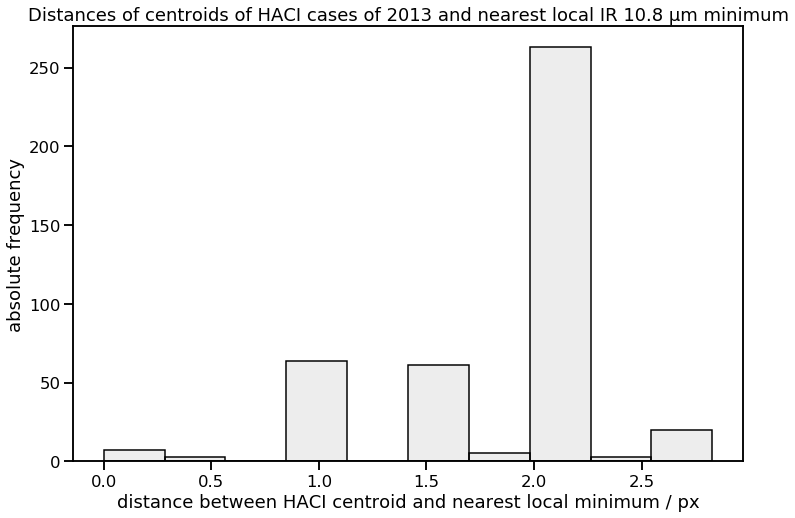

In [48]:
fig,ax =plt.subplots(1,1,figsize=(12,8))
plt.sca(ax)
plt.hist(np.array(centroid_distances)[~np.isnan(np.array(centroid_distances))],
         bins=10,color='#00000012',edgecolor='k')
ax.set_xlabel("distance between HACI centroid and nearest local minimum / px")
ax.set_ylabel("absolute frequency")
ax.set_title("Distances of centroids of HACI cases of 2013 and nearest local IR 10.8 µm minimum")

In [49]:
distance_is_nan = len(np.where(np.isnan(np.array(centroid_distances)))[0])

In [50]:
distance_not_nan = len(np.where(~np.isnan(np.array(centroid_distances)))[0])

Bei den HACI-Fällen für 2013 sind Entfernungen zum nächsten lokalen Minimum zwischen kleiner als 0,5&thinsp;px bis über 2,5&thinsp;px vertreten, wobei die meisten Fälle bei 2&thinsp;px liegen. Das heißt zum Auslösungszeitpunkt haben die meisten zu den HACI-Fällen gehörigen Wolken eine Wolkenhöhe von ca. 6&thinsp;km bis 8&thinsp;km. Das sind Werte in der mittleren Troposphäre und ähnlich zu den in der Literatur beschriebenen. Das sieht also vernünftig aus.

Für 62% der Fälle war es nicht möglich im verwendeten Umkreis ein zugehöriges lokales Minimum zu finden. Das kann mehrere Ursachen haben:

1. Die Wolke ist zu warm, um ein lokales Minimum mit einer Tiefe von &geq;&thinsp;5&thinsp;K zu haben
2. Es handelt sich um ein nichtmeteorlogisches Echo
3. Das zugehörige lokale Minimum ist weiter entfernt, als der ausgewählte Umkreis.

Aber im Großen und Ganzen sollten wir alle Fälle mit einem sinnvollen lokalen Minimum in einer erwartbaren Entfernung gefunden haben.